<a href="https://colab.research.google.com/github/kirank981/Project_space/blob/main/project_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependences


Install the necessary packages for PyTorch (torch and torchvision) and Flower (flwr) and pandas

In [ ]:
# !pip install -q flwr[simulation] torch torchvision matplotlib pandas

Import everything we need

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

from google.colab import drive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import CIFAR10



from sklearn.model_selection import train_test_split  # Import the train_test_split function
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

!pip install catboost
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# from tensorflow.keras.layers import Conv2D, Multiply, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Multiply

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [ ]:
# Importing more modules
import os
import urllib.request
import bz2
import shutil

!nvidia-smi
!pip install matplotlib scikit-learn tqdm torch torchmetrics torchsummary xgboost
!pip install -U "flwr-nightly[simulation]"

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_svmlight_file

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchmetrics import Accuracy, MeanSquaredError
from tqdm import trange, tqdm
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, random_split

# Flower related modules for federated XGBoost
import flwr as fl
from flwr.common.typing import Parameters
from collections import OrderedDict
from typing import Any, Dict, List, Optional, Tuple, Union
from flwr.common import NDArray, NDArrays

from matplotlib import pyplot as plt

Mon Aug 21 19:09:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    26W /  70W |   1153MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading the data

Mounting drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting the path to the location of the file

In [ ]:
# Define the path to daily dataset folder
daily_dataset_path = Path('/content/drive/MyDrive/Federated learning implementation/dataset/dataset_archive/daily_dataset/daily_dataset')

# Define the path to daily dataset folder
weather_daily_dataset_path = Path('/content/drive/MyDrive/Federated learning implementation/dataset/dataset_archive/weather_daily_dataset.csv')


## Loading daily data
(of energy consumption)


In [ ]:

# Initializing list to store dataframes
dfs = []

# Loop through the CSV files and reading them into dataframes
for i in range(1):
    filename = f'block_{i}.csv'
    df = pd.read_csv(daily_dataset_path / filename)
    dfs.append(df)

# Concatenating all the dataframes into a single dataframe
energy_daily_data = pd.concat(dfs, ignore_index=True)

# NRATM(Not Required At The Moment)
# # Group the data by LCLid and create a dictionary of dataframes
# grouped_data = dict(tuple(energy_daily_data.groupby('LCLid')))


Loading data using file name

In [ ]:
# Loading data from a specific CSV file
specific_file_data = pd.read_csv(daily_dataset_path / 'LCLid_3nos.csv')

# Displaying data
print(specific_file_data)

          LCLid         day  energy_median  energy_mean  energy_max  \
0     MAC000002  2012-10-12         0.1385     0.154304       0.886   
1     MAC000002  2012-10-13         0.1800     0.230979       0.933   
2     MAC000002  2012-10-14         0.1580     0.275479       1.085   
3     MAC000002  2012-10-15         0.1310     0.213688       1.164   
4     MAC000002  2012-10-16         0.1450     0.203521       0.991   
...         ...         ...            ...          ...         ...   
1316  MAC000246  2014-02-23         0.4850     0.619083       1.644   
1317  MAC000246  2014-02-24         0.1245     0.394479       2.643   
1318  MAC000246  2014-02-25         0.2870     0.494104       2.205   
1319  MAC000246  2014-02-26         0.2570     0.324208       1.158   
1320  MAC000246  2014-02-27         0.1365     0.333875       2.436   

      energy_count  energy_std  energy_sum  energy_min  
0               46    0.196034       7.098       0.000  
1               48    0.192329   

### Loading required data
Creating a DataFrame that have only the required data

In [ ]:
selected_column = ['LCLid','energy_sum','day']
energy_daily_selected=energy_daily_data[selected_column] #(check)
# energy_daily_selected=specific_file_data[selected_column]
# print(energy_daily_selected)

# Group the data by LCLid and create a dictionary of dataframes, allowing to access each dataframe separately using the LCLid as the key
grouped_data_selected = dict(tuple(energy_daily_selected.groupby('LCLid')))
# Display the data for 'MAC000002'
print('\n')
print('Data report of MAC000002')
print(grouped_data_selected['MAC000002'])




Data report of MAC000002
         LCLid  energy_sum         day
0    MAC000002       7.098  2012-10-12
1    MAC000002      11.087  2012-10-13
2    MAC000002      13.223  2012-10-14
3    MAC000002      10.257  2012-10-15
4    MAC000002       9.769  2012-10-16
..         ...         ...         ...
500  MAC000002      12.528  2014-02-24
501  MAC000002      11.826  2014-02-25
502  MAC000002      12.328  2014-02-26
503  MAC000002      20.518  2014-02-27
504  MAC000002       1.387  2014-02-28

[505 rows x 3 columns]


## Loading daily weather data

Creating a 'day' column that stores only the date values from 'time' column
(for linking weather dataset 'day' with daily dataset 'day')

In [ ]:
# Load the weather dataset into a DataFrame
weather_daily_data = pd.read_csv(weather_daily_dataset_path)

# Convert the 'time' column to datetime format
weather_daily_data['time'] = pd.to_datetime(weather_daily_data['time'])

# Calculate the mean temperature for each day and store it in a new column 'mean_temp'
weather_daily_data['mean_temp'] = (weather_daily_data['temperatureMax'] + weather_daily_data['temperatureMin']) / 2

# Print the updated DataFrame
print(weather_daily_data)

     temperatureMax   temperatureMaxTime  windBearing                 icon  \
0             11.96  2011-11-11 23:00:00          123                  fog   
1              8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2             10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3              8.07  2011-12-02 23:00:00          232                 wind   
4              8.22  2011-12-24 23:00:00          252  partly-cloudy-night   
..              ...                  ...          ...                  ...   
877            9.03  2014-01-26 16:00:00          233    partly-cloudy-day   
878           10.31  2014-02-27 14:00:00          224    partly-cloudy-day   
879           18.97  2014-03-09 14:00:00          172  partly-cloudy-night   
880            8.83  2014-02-12 16:00:00          210                 wind   
881            9.90  2014-02-15 12:00:00          233                 wind   

     dewPoint   temperatureMinTime  cloudCover  windSpeed  pres

### Loading required data
Creating a DataFrame that have only the required data

In [ ]:
# Create a new DataFrame with selected columns
selected_columns = ['mean_temp', 'pressure', 'humidity', 'windSpeed', 'time']
weather_selected = weather_daily_data[selected_columns]

# Print the new dataset
print(weather_selected)

     mean_temp  pressure  humidity  windSpeed       time
0       10.405   1016.08      0.95       3.88 2011-11-11
1        5.535   1007.71      0.88       3.94 2011-12-11
2        9.180   1032.76      0.74       3.54 2011-12-27
3        5.315   1012.12      0.87       3.00 2011-12-02
4        5.695   1028.17      0.80       4.46 2011-12-24
..         ...       ...       ...        ...        ...
877      6.145   1002.10      0.79       4.55 2014-01-26
878      7.120   1007.02      0.74       4.14 2014-02-27
879     13.310   1022.44      0.58       2.78 2014-03-09
880      5.930    994.27      0.75       7.24 2014-02-12
881      7.640    988.63      0.69       9.96 2014-02-15

[882 rows x 5 columns]


# Dataset with Household energy consumption values and weather values

## For all households

In [ ]:
# Convert 'time' column in weather_selected to datetime objects
weather_selected['time'] = pd.to_datetime(weather_selected['time'])

# Create a list to store the merged data DataFrames
merged_data_list = []

# Iterate through each LCLid in energy_daily_selected
for lclid, data in grouped_data_selected.items():
    # Convert 'day' column in current LCLid data to datetime objects
    data['day'] = pd.to_datetime(data['day'])

    # Merge the current LCLid data with weather_selected based on the common date values
    merged_data_lclid = pd.merge(weather_selected, data, left_on='time', right_on='day', how='inner')

    # Drop the redundant 'day' column from the merged data
    merged_data_lclid.drop(columns=['day'], inplace=True)

    # Append the merged data to the merged_data_list
    merged_data_list.append(merged_data_lclid)

# Concatenate the merged data DataFrames in the list
merged_data = pd.concat(merged_data_list, ignore_index=True)

# Display the merged dataset
print(merged_data)


<ipython-input-161-fc90630300b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_selected['time'] = pd.to_datetime(weather_selected['time'])


         mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0           10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1           12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2            7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3            5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4            4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
...            ...       ...       ...        ...        ...        ...   
1542386      4.470   1001.76      0.91       1.52 2014-01-30  MAC005567   
1542387      6.145   1002.10      0.79       4.55 2014-01-26  MAC005567   
1542388      7.120   1007.02      0.74       4.14 2014-02-27  MAC005567   
1542389      5.930    994.27      0.75       7.24 2014-02-12  MAC005567   
1542390      7.640    988.63      0.69       9.96 2014-02-15  MAC005567   

         energy_sum  
0            10.545  
1            11.221  
2            12.209  
3          

## For one household

In [ ]:
print(merged_data[merged_data['LCLid'] == "MAC000002"])

     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0       10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1       12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2        7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3        5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4        4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
..         ...       ...       ...        ...        ...        ...   
273      4.470   1001.76      0.91       1.52 2014-01-30  MAC000002   
274      6.145   1002.10      0.79       4.55 2014-01-26  MAC000002   
275      7.120   1007.02      0.74       4.14 2014-02-27  MAC000002   
276      5.930    994.27      0.75       7.24 2014-02-12  MAC000002   
277      7.640    988.63      0.69       9.96 2014-02-15  MAC000002   

     energy_sum  
0        10.545  
1        11.221  
2        12.209  
3        11.663  
4        13.248  
..          ...  
273      14.166  
274

# Splitting dataset to training and testing sets



## Preprocessing dataset

### Counting amount of data for each LCLid (data available for each household)

In [ ]:
# Convert 'time' column in weather_selected to datetime objects
weather_selected['time'] = pd.to_datetime(weather_selected['time'])

# Merge the data into merged_data DataFrame as described in your previous code

# Count the number of data rows for each LCLid
lclid_data_counts = merged_data['LCLid'].value_counts()

# Display the counts for each LCLid
print("Data row counts for each LCLid:")
print(lclid_data_counts)



Data row counts for each LCLid:
MAC000145    402
MAC000147    402
MAC000148    402
MAC000149    402
MAC000150    402
            ... 
MAC005560      1
MAC001150      1
MAC005563      1
MAC001957      1
MAC005565      1
Name: LCLid, Length: 5550, dtype: int64


<ipython-input-163-27ee962d4454>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_selected['time'] = pd.to_datetime(weather_selected['time'])


### Identifiting the no of households with insufficient amount of data

In [ ]:
# Count the number of data rows for each LCLid
lclid_data_counts = merged_data['LCLid'].value_counts()


# Get the total number of unique LCLid values
total_lclids = len(lclid_data_counts)

# Count the number of LCLid values with less than 100 data rows
count_less_than_100 = (lclid_data_counts < 100).sum()

# Display the count of LCLid values with less than 100 data rows
print("Number of LCLid values with less than 100 data rows:", count_less_than_100)

# Display the total number of unique LCLid values
print("Total number of unique LCLid values:", total_lclids)

Number of LCLid values with less than 100 data rows: 61
Total number of unique LCLid values: 5550


### Removing the households with less data, from the dataset

In [ ]:
# Get the list of LCLid values with less than 100 data rows
lclids_to_remove = lclid_data_counts[lclid_data_counts < 100].index

# Remove rows corresponding to LCLid values with less than 100 data rows
filtered_data = merged_data[~merged_data['LCLid'].isin(lclids_to_remove)]

# also removing rows with NaN values in the dataset
filtered_data = filtered_data.dropna()

# Display the filtered data
print(filtered_data)

         mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0           10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1           12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2            7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3            5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4            4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
...            ...       ...       ...        ...        ...        ...   
1542386      4.470   1001.76      0.91       1.52 2014-01-30  MAC005567   
1542387      6.145   1002.10      0.79       4.55 2014-01-26  MAC005567   
1542388      7.120   1007.02      0.74       4.14 2014-02-27  MAC005567   
1542389      5.930    994.27      0.75       7.24 2014-02-12  MAC005567   
1542390      7.640    988.63      0.69       9.96 2014-02-15  MAC005567   

         energy_sum  
0            10.545  
1            11.221  
2            12.209  
3          

In [ ]:
# Count the number of data rows for each LCLid
lclid_data_counts = filtered_data['LCLid'].value_counts()


# Get the total number of unique LCLid values
total_lclids = len(lclid_data_counts)

# Count the number of LCLid values with less than 100 data rows
count_less_than_100 = (lclid_data_counts < 100).sum()

# Display the count of LCLid values with less than 100 data rows
print("Number of LCLid values with less than 100 data rows:", count_less_than_100)

# Display the total number of unique LCLid values
print("Total number of unique LCLid values:", total_lclids)

Number of LCLid values with less than 100 data rows: 0
Total number of unique LCLid values: 5489


## Splitting the dataset to train and test
 where the split ratio(70:30) is made with every househould's data.

In [ ]:
from sklearn.model_selection import train_test_split

# Define the split percentages
train_percentage = 0.6 # 60% for training
val_percentage = 0.3   # 30% for validation
test_percentage = 0.3  # 30% for testing
min_data_points = 10   # Minimum number of data points required for an LCLid

# Create lists to store DataFrames for training, validation, and testing
train_data_list = []
val_data_list = []
test_data_list = []

# Iterate through each unique LCLid and split the data based on train_percentage, val_percentage, and test_percentage
unique_lclids = filtered_data['LCLid'].unique()
for lclid in unique_lclids:
    lclid_data = filtered_data[filtered_data['LCLid'] == lclid]

    # Check if there are sufficient data points for the current LCLid
    if len(lclid_data) >= min_data_points:
        # Split the data for the current LCLid into training, validation, and test sets
        train_data_lclid, remaining_data_lclid = train_test_split(lclid_data, train_size=train_percentage, shuffle=False)
        val_data_lclid, test_data_lclid = train_test_split(remaining_data_lclid, train_size=val_percentage/(val_percentage + test_percentage), shuffle=False)

        # Randomize the rows within each subset
        train_data_lclid = train_data_lclid.sample(frac=1, random_state=42)
        val_data_lclid = val_data_lclid.sample(frac=1, random_state=42)
        test_data_lclid = test_data_lclid.sample(frac=1, random_state=42)

        # Append to the train_data_list, val_data_list, and test_data_list
        train_data_list.append(train_data_lclid)
        val_data_list.append(val_data_lclid)
        test_data_list.append(test_data_lclid)

# Concatenate the DataFrames in the lists
FL_train_set = pd.concat(train_data_list, ignore_index=True)
FL_val_set = pd.concat(val_data_list, ignore_index=True)
FL_test_set = pd.concat(test_data_list, ignore_index=True)

# Store the training, validation, and test sets in separate lists
FL_train_sets_list = train_data_list
FL_val_sets_list = val_data_list
FL_test_sets_list = test_data_list

# Display the training, validation, and test sets
print("Training set:")
print(FL_train_set)
print("Validation set:")
print(FL_val_set)
print("Test set:")
print(FL_test_set)


### For FL training, validation and test sets

In [ ]:
# Display the first training set
print("First Training set:")
print(FL_train_sets_list[0])
print("First Validation set:")
print(FL_val_sets_list[0])
print("First Test set:")
print(FL_test_sets_list[0])

In [ ]:
# Display the first training set
print("First Training set:")
print(FL_train_sets_list[1])
print("First Validation set:")
print(FL_val_sets_list[1])
print("First Test set:")
print(FL_test_sets_list[1])

### Centralised training, validation and test sets

In [ ]:

# Copy FL training set to central training set
Central_train_data = FL_train_set.copy()

# Copy FL validation set to central validation set
Central_val_data = FL_val_set.copy()

# Copy FL test set to central test set
Central_test_data = FL_test_set.copy()

# Display the sizes of the sets
print("Central Training set size:", len(Central_train_data))
print("Central Validation set size:", len(Central_val_data))
print("Central Test set size:", len(Central_test_data))



Displaying training, validation and test sets

In [ ]:
# Display the training and test sets
print("Training set:")
print(Central_train_data)
print("Validation set:")
print(Central_val_data)
print("Test set:")
print(Central_test_data)


# Centralised Training

## Defining features and target column

In [ ]:
# Separate features and target variable
Central_X_train = Central_train_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_train = Central_train_data['energy_sum']

# Separate features and target variable
Central_X_val = Central_val_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_val = Central_val_data['energy_sum']

# Separate features and target variable
Central_X_test = Central_test_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_test = Central_test_data['energy_sum']


## Preprocessing (scaler and imputer)

In [ ]:
# Define the datasets
datasets = [
    (Central_X_train, Central_y_train, "Central Training"),
    (Central_X_val, Central_y_val, "Central Validation"),
    (Central_X_test, Central_y_test, "Central Test")
]

# Preprocess each dataset
for X, y, name in datasets:
    # Impute missing values and scale features
    X_scaled = StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(X))

    # Display dataset name and shape
    print(f"{name} Dataset:")
    print("Original Shape:", X.shape)
    print("Preprocessed Shape:", X_scaled.shape)
    print()

In [ ]:
# Check for missing values
print(Central_y_train.isnull().sum())
print(Central_X_train.isnull().sum())

# Replace missing values with mean (you can choose another strategy)
Central_y_train.fillna(Central_y_train.mean(), inplace=True)
Central_X_train.fillna(Central_X_train.mean(), inplace=True)

# Check for missing values
print(Central_y_train.isnull().sum())
print(Central_X_train.isnull().sum())

## Model selection

In [ ]:

# # List of models to train
# models = [
#     LinearRegression(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(),
#     GradientBoostingRegressor(),
#     XGBRegressor(),
#     LGBMRegressor(),
#     CatBoostRegressor(),
#     SVR(),
#     MLPRegressor(),
#     KNeighborsRegressor()
# ]

# # Dictionary to store model performances
# model_performances = {}

# # Train and evaluate each model on the validation set
# for model in models:
#     model_name = model.__class__.__name__
#     print(f"Training {model_name}...")
#     model.fit(Central_X_train, Central_y_train)

#     # Predict on the validation set
#     y_pred_val = model.predict(Central_X_val)
#     # print(y_pred_val)

#     # Calculate Mean Squared Error
#     # mse_val = mean_squared_error(Central_y_val, y_pred_val)
#     model_performances[model_name] = (Central_y_val-y_pred_val)
#     print(model_performances[model_name])

# # Find the best-performing model
# best_model = min(model_performances, key=model_performances.get)
# print(f"Best-performing model: {best_model} (MSE: {model_performances[best_model]})")


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
xgb_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=0)

# Remove rows with missing values from both features and target variables
Central_train_data_cleaned = Central_train_data.dropna()
Central_X_train = Central_train_data_cleaned[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_train = Central_train_data_cleaned['energy_sum']

# Drop rows with NaN values in the target variable in the validation set
Central_val_data.dropna(subset=['energy_sum'], inplace=True)

# Train linear model
linear_model.fit(Central_X_train, Central_y_train)

# Train random forest model
rf_model.fit(Central_X_train, Central_y_train)

# Train XGBoost model
xgb_model.fit(Central_X_train, Central_y_train)


In [ ]:
# Build a simple feedforward neural network(FNN)
fnn_model = keras.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

fnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
fnn_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_data=(Central_X_val, Central_y_val))

In [ ]:
# Building a simple RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Create an RNN model
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(Central_X_train.shape[1], 1)))
simple_rnn_model.add(Dense(1))

# Compile the model
simple_rnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Train the model
simple_rnn_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_data=(Central_X_val, Central_y_val))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM input (samples, timesteps, features)
num_timesteps = 1
num_features = Central_X_train.shape[1]

X_train_reshaped = Central_X_train.values.reshape((Central_X_train.shape[0], num_timesteps, num_features))
X_val_reshaped = Central_X_val.values.reshape((Central_X_val.shape[0], num_timesteps, num_features))

# Create an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(num_timesteps, num_features)))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(loss='mse', optimizer='adam')

# Train the model
lstm_model.fit(X_train_reshaped, Central_y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, Central_y_val))


### Defining the Evaluation function

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Store the evaluation results for each model
eval_results = []

def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"Model: {model.__class__.__name__}")
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)
    print("R-squared variance:", r2*100)
    print()
    return mse, rmse, mae, r2


### Using the Evaluation Function

In [ ]:
# Define the models as trained earlier
models = [
    ('Linear Regression', linear_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
    ('Neural Network', fnn_model),
    ('RNN',simple_rnn_model),
    ('LSTM',lstm_model)
]

# Store the evaluation results for each model
eval_results = []

# Evaluate each model and store results
for model_name, model in models:
    if model_name == 'LSTM':
        X_val_reshaped = Central_X_val.values.reshape((Central_X_val.shape[0], num_timesteps, num_features))
        mse, rmse, mae, r2 = evaluate_model(model, X_val_reshaped, Central_y_val)
    else:
        mse, rmse, mae, r2 = evaluate_model(model, Central_X_val, Central_y_val)

    eval_results.append((model_name, mse, rmse, mae, r2))

# Convert eval_results to a numpy array for plotting
eval_results = np.array(eval_results)

# Plot the evaluation metrics for each model
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(x, eval_results[:, i + 1].astype(float), tick_label=eval_results[:, 0])
    plt.title(metric)
    plt.xticks(rotation=15)
    plt.tight_layout()

plt.show()


### Hypertuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Create GridSearchCV instance
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Train the model using GridSearchCV
grid_search.fit(Central_X_train, Central_y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

In [ ]:
# best_xgb_model.fit(FL_val_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']],FL_val_set['energy_sum'])
best_xgb_model.fit(Central_X_train, Central_y_train)

In [ ]:
best_mse, best_rmse, best_mae, best_r2=evaluate_model(best_xgb_model, Central_X_test, Central_y_test)

# Federated Approach

## Utility function for xgboost trees

In [ ]:

def construct_tree(
    dataset: Dataset, label: NDArray, n_estimators: int, tree_type: str
) -> XGBRegressor:
    """Construct a xgboost tree form tabular dataset."""
    if tree_type == "REG":
      tree = xgb.XGBRegressor(
          objective="reg:squarederror",
          learning_rate=0.1,
          max_depth=8,
          n_estimators=n_estimators,
          subsample=0.8,
          colsample_bylevel=1,
          colsample_bynode=1,
          colsample_bytree=1,
          alpha=5,
          gamma=5,
          num_parallel_tree=1,
          min_child_weight=1,
      )

    tree.fit(dataset, label)
    return tree

def construct_tree_from_loader(
    dataset_loader: DataLoader, n_estimators: int, tree_type: str
) -> XGBRegressor:
    """Construct a xgboost tree form tabular dataset loader."""
    for dataset in dataset_loader:
        data, label = dataset[0], dataset[1]
    return construct_tree(data, label, n_estimators, tree_type)

def single_tree_prediction(
    tree: XGBRegressor, n_tree: int, dataset: NDArray
) -> Optional[NDArray]:
    """Extract the prediction result of a single tree in the xgboost tree
    ensemble."""
    num_t = len(tree.get_booster().get_dump())
    if n_tree > num_t:
        print(
            "The tree index to be extracted is larger than the total number of trees."
        )
        return None

    return tree.predict(
        dataset, iteration_range=(n_tree, n_tree + 1), output_margin=True
    )

def tree_encoding(
    trainloader: DataLoader,
    client_trees: Union[
        Tuple[XGBRegressor, int],
        List[Tuple[XGBRegressor, int]],
    ],
    client_tree_num: int,
    client_num: int,
) -> Optional[Tuple[NDArray, NDArray]]:
    """Transform the tabular dataset into prediction results using the
    aggregated xgboost tree ensembles from all clients."""
    if trainloader is None:
        return None

    for local_dataset in trainloader:
        x_train, y_train = local_dataset[0], local_dataset[1]

    x_train_enc = np.zeros((x_train.shape[0], client_num * client_tree_num))
    x_train_enc = np.array(x_train_enc, copy=True)

    temp_trees: Any = None
    if isinstance(client_trees, list) is False:
        temp_trees = [client_trees[0]] * client_num
    elif isinstance(client_trees, list) and len(client_trees) != client_num:
        temp_trees = [client_trees[0][0]] * client_num
    else:
        cids = []
        temp_trees = []
        for i, _ in enumerate(client_trees):
            temp_trees.append(client_trees[i][0])  # type: ignore
            cids.append(client_trees[i][1])  # type: ignore
        sorted_index = np.argsort(np.asarray(cids))
        temp_trees = np.asarray(temp_trees)[sorted_index]

    for i, _ in enumerate(temp_trees):
        for j in range(client_tree_num):
            x_train_enc[:, i * client_tree_num + j] = single_tree_prediction(
                temp_trees[i], j, x_train
            )

    x_train_enc32: Any = np.float32(x_train_enc)
    y_train32: Any = np.float32(y_train)

    x_train_enc32, y_train32 = torch.from_numpy(
        np.expand_dims(x_train_enc32, axis=1)  # type: ignore
    ), torch.from_numpy(
        np.expand_dims(y_train32, axis=-1)  # type: ignore
    )
    return x_train_enc32, y_train32


# def plot_xgbtree(tree: XGBRegressor, n_tree: int) -> None:
#     """Visualize the built xgboost tree."""
#     xgb.plot_tree(tree, num_trees=n_tree)
#     plt.rcParams["figure.figsize"] = [50, 10]
#     plt.show()


## Data for FL

### Setting/defining data from dataset for FL

In [ ]:
reg_train = FL_train_set
reg_test = FL_test_set
task_type = "REG"

# Select the downloaded training and test dataset
if task_type == "REG":
    train = reg_train
    test = reg_test
    data_train = reg_train
    data_test = reg_test

print("Task type selected is: " + task_type)
print("Training dataset is: ")
print(train)
print("Test dataset is: ")
print(test)

### Loading data

In [ ]:
class TreeDataset(Dataset):
    def __init__(self, data: NDArray, labels: NDArray) -> None:
        self.labels = labels
        self.data = data

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[int, NDArray]:
        label = self.labels[idx]
        data = self.data[idx, :]
        sample = {0: data, 1: label}
        return sample

task_type = "REG"

# Load and preprocess regression data
X_train = FL_train_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
y_train = FL_train_set['energy_sum'].values

X_test = FL_test_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
y_test = FL_test_set['energy_sum'].values

X_train.flags.writeable = True
y_train.flags.writeable = True

X_test.flags.writeable = True
y_test.flags.writeable = True

print("Feature dimension of the dataset:", X_train.shape[1])
print("Size of the trainset:", X_train.shape[0])
print("Size of the testset:", X_test.shape[0])
assert X_train.shape[1] == X_test.shape[1]

trainset = TreeDataset(np.array(X_train, copy=True), np.array(y_train, copy=True))
testset = TreeDataset(np.array(X_test, copy=True), np.array(y_test, copy=True))
print(trainset)
print(testset)


### Partitioning data for training, validation and testing

In [ ]:
def get_dataloader(
    dataset: Dataset, partition: str, batch_size: Union[int, str]
) -> DataLoader:
    if batch_size == "whole":
        batch_size = len(dataset)
    return DataLoader(
        dataset, batch_size=batch_size, pin_memory=True, shuffle=(partition == "train")
    )

def do_fl_partitioning(
    trainset: Dataset,
    testset: Dataset,
    pool_size: int,
    batch_size: Union[int, str],
    val_ratio: float = 0.0,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // pool_size
    lengths = [partition_size] * pool_size
    if sum(lengths) != len(trainset):
        lengths[-1] = len(trainset) - sum(lengths[0:-1])
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(0))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = int(len(ds) * val_ratio)
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(0))
        trainloaders.append(get_dataloader(ds_train, "train", batch_size))
        if len_val != 0:
            valloaders.append(get_dataloader(ds_val, "val", batch_size))
        else:
            valloaders = None
    testloader = get_dataloader(testset, "test", batch_size)

    # columns_to_extract = ['mean_temp', 'pressure', 'humidity', 'windSpeed', 'energy_sum']
    # trainloaders = [get_dataloader(dataset, "train", batch_size) for dataset in FL_train_sets_list]

    # trainloaders=FL_train_sets_list[['mean_temp', 'pressure', 'humidity', 'windSpeed','energy_sum']]
    # valloaders=FL_val_sets_list[['mean_temp', 'pressure', 'humidity', 'windSpeed','energy_sum']]
    # testloader=FL_test_sets_list[['mean_temp', 'pressure', 'humidity', 'windSpeed','energy_sum']]


    return trainloaders, valloaders, testloader

## Global variables of FL appraoch

In [ ]:
# The number of clients participated in the federated learning
# client_num = 2      #from file "LCLid_3nos.csv"
# client_num= 49    #from file "block_0"
client_num= 5489  #from all files

# The number of XGBoost trees in the tree ensemble that will be built for each client
client_tree_num = 500 // client_num

### Creating a global XGBoost tree for comparison
(not using)

In [ ]:

# print(X_train)
# print(FL_train_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']])
global_tree = construct_tree(X_train, y_train, client_tree_num, task_type)
preds_train = global_tree.predict(X_train)
preds_test = global_tree.predict(X_test)

result_train = mean_squared_error(y_train, preds_train)
result_test = mean_squared_error(y_test, preds_test)
print("Global XGBoost Training MSE: %f" % (result_train))
print("Global XGBoost Testing MSE: %f" % (result_test))
# print(y_train)
# print(y_test)
# print(X_train)

print(global_tree)


Global XGBoost Training MSE: 529.466870
Global XGBoost Testing MSE: 522.619592
XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=5, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=1, predictor=None, ...)


### Creating a local XGBoost trees on clients for comparison
(not using)

In [ ]:
client_trees_comparison = []
trainloaders, _, testloader = do_fl_partitioning(
    trainset, testset, pool_size=client_num, batch_size="whole", val_ratio=0.0
)
for i, trainloader in enumerate(trainloaders):
    for local_dataset in trainloader:
        local_X_train, local_y_train = local_dataset[0], local_dataset[1]
        tree = construct_tree(local_X_train, local_y_train, client_tree_num, task_type)
        client_trees_comparison.append(tree)

        preds_train = client_trees_comparison[-1].predict(local_X_train)
        preds_test = client_trees_comparison[-1].predict(X_test)

        result_train = mean_squared_error(local_y_train, preds_train)
        result_test = mean_squared_error(y_test, preds_test)
        print("Local Client %d XGBoost Training MSE: %f" % (i, result_train))
        print("Local Client %d XGBoost Testing MSE: %f" % (i, result_test))


Local Client 0 XGBoost Training MSE: 607.460855
Local Client 0 XGBoost Testing MSE: 572.516306
Local Client 1 XGBoost Training MSE: 266.231035
Local Client 1 XGBoost Testing MSE: 569.009708
Local Client 2 XGBoost Training MSE: 426.089375
Local Client 2 XGBoost Testing MSE: 538.122223
Local Client 3 XGBoost Training MSE: 287.580474
Local Client 3 XGBoost Testing MSE: 540.464117
Local Client 4 XGBoost Training MSE: 589.493076
Local Client 4 XGBoost Testing MSE: 487.875004
Local Client 5 XGBoost Training MSE: 452.891709
Local Client 5 XGBoost Testing MSE: 589.639899
Local Client 6 XGBoost Training MSE: 195.158622
Local Client 6 XGBoost Testing MSE: 563.148558
Local Client 7 XGBoost Training MSE: 342.188427
Local Client 7 XGBoost Testing MSE: 573.943445
Local Client 8 XGBoost Training MSE: 402.856018
Local Client 8 XGBoost Testing MSE: 604.980203
Local Client 9 XGBoost Training MSE: 437.879564
Local Client 9 XGBoost Testing MSE: 545.615599
Local Client 10 XGBoost Training MSE: 348.303309
L

## Developing a CNN model(on tree predictions) for making the learning rate of the XGBoost model learnable

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_channel: int = 64) -> None:
        super(CNN, self).__init__()
        n_out = 1
        self.task_type = task_type
        self.conv1d = nn.Conv1d(
            1, n_channel, kernel_size=client_tree_num, stride=client_tree_num, padding=0
        )
        self.layer_direct = nn.Linear(n_channel * client_num, n_out)
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Identity = nn.Identity()

        # Add weight initialization
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(
                    layer.weight, mode="fan_in", nonlinearity="relu"
                )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.ReLU(self.conv1d(x))
        x = x.flatten(start_dim=1)
        x = self.ReLU(x)
        x = self.Identity(self.layer_direct(x))
        return x

    def get_weights(self) -> fl.common.NDArrays:
        """Get model weights as a list of NumPy ndarrays."""
        return [
            np.array(val.cpu().numpy(), copy=True)
            for _, val in self.state_dict().items()
        ]

    def set_weights(self, weights: fl.common.NDArrays) -> None:
        """Set model weights from a list of NumPy ndarrays."""
        layer_dict = {}
        for k, v in zip(self.state_dict().keys(), weights):
            if v.ndim != 0:
                layer_dict[k] = torch.Tensor(np.array(v, copy=True))
        state_dict = OrderedDict(layer_dict)
        self.load_state_dict(state_dict, strict=True)


def train(
    task_type: str,
    net: CNN,
    trainloader: DataLoader,
    device: torch.device,
    num_iterations: int,
    log_progress: bool = True,
) -> Tuple[float, float, int]:
    # Define loss and optimizer
    criterion = nn.MSELoss()
    # optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

    def cycle(iterable):
        """Repeats the contents of the train loader, in case it gets exhausted in 'num_iterations'."""
        while True:
            for x in iterable:
                yield x

    # Train the network
    net.train()
    total_loss, total_result, n_samples = 0.0, 0.0, 0
    pbar = (
        tqdm(iter(cycle(trainloader)), total=num_iterations, desc=f"TRAIN")
        if log_progress
        else iter(cycle(trainloader))
    )

    # Unusually, this training is formulated in terms of number of updates/iterations/batches processed
    # by the network. This will be helpful later on, when partitioning the data across clients: resulting
    # in differences between dataset sizes and hence inconsistent numbers of updates per 'epoch'.
    for i, data in zip(range(num_iterations), pbar):
        tree_outputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(tree_outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Collected training loss and accuracy statistics
        total_loss += loss.item()
        n_samples += labels.size(0)

        if task_type == "REG":
            mse = MeanSquaredError()(outputs, labels.type(torch.int))
            total_result += mse * labels.size(0)

        if log_progress:
             if task_type == "REG":
                pbar.set_postfix(
                    {
                        "train_loss": total_loss / n_samples,
                        "train_mse": total_result / n_samples,
                    }
                )
    if log_progress:
        print("\n")

    return total_loss / n_samples, total_result / n_samples, n_samples


def test(
    task_type: str,
    net: CNN,
    testloader: DataLoader,
    device: torch.device,
    log_progress: bool = True,
) -> Tuple[float, float, int]:
    """Evaluates the network on test data."""
    if task_type == "REG":
        criterion = nn.MSELoss()

    total_loss, total_result, n_samples = 0.0, 0.0, 0
    net.eval()
    with torch.no_grad():
        pbar = tqdm(testloader, desc="TEST") if log_progress else testloader
        for data in pbar:
            tree_outputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(tree_outputs)

            # Collected testing loss and accuracy statistics
            total_loss += criterion(outputs, labels).item()
            n_samples += labels.size(0)

            if task_type == "REG":
                mse = MeanSquaredError()(outputs.cpu(), labels.type(torch.int).cpu())
                total_result += mse * labels.size(0)

    if log_progress:
        print("\n")

    return total_loss / n_samples, total_result / n_samples, n_samples

## FLower Client

In [ ]:
# Flower client
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetPropertiesIns,
    GetPropertiesRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    Code,
    parameters_to_ndarrays,
    ndarrays_to_parameters,
)

In [ ]:
def tree_encoding_loader(
    dataloader: DataLoader,
    batch_size: int,
    client_trees: Union[
        Tuple[XGBRegressor, int],
        List[Tuple[XGBRegressor, int]],
    ],
    client_tree_num: int,
    client_num: int,
) -> DataLoader:
    encoding = tree_encoding(dataloader, client_trees, client_tree_num, client_num)
    if encoding is None:
        return None
    data, labels = encoding
    tree_dataset = TreeDataset(data, labels)
    return get_dataloader(tree_dataset, "tree", batch_size)

class FL_Client(fl.client.Client):
    def __init__(
        self,
        task_type: str,
        trainloader: DataLoader,
        valloader: DataLoader,
        client_tree_num: int,
        client_num: int,
        cid: str,
        log_progress: bool = False,
    ):
        """
        Creates a client for training `network.Net` on tabular dataset.
        """
        self.task_type = task_type
        self.cid = cid
        self.tree = construct_tree_from_loader(trainloader, client_tree_num, task_type)
        self.trainloader_original = trainloader
        self.valloader_original = valloader
        self.trainloader = None
        self.valloader = None
        self.client_tree_num = client_tree_num
        self.client_num = client_num
        self.properties = {"tensor_type": "numpy.ndarray"}
        self.log_progress = log_progress

        # instantiate model
        self.net = CNN()

        # determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def get_properties(self, ins: GetPropertiesIns) -> GetPropertiesRes:
        return GetPropertiesRes(properties=self.properties)

    def get_parameters(
        self, ins: GetParametersIns
    ) -> Tuple[
        GetParametersRes,  Tuple[XGBRegressor, int]
    ]:
        return [
            GetParametersRes(
                status=Status(Code.OK, ""),
                parameters=ndarrays_to_parameters(self.net.get_weights()),
            ),
            (self.tree, int(self.cid)),
        ]

    def set_parameters(
        self,
        parameters: Tuple[
            Parameters,
            Union[
                Tuple[XGBRegressor, int],
                List[Tuple[XGBRegressor, int]],
            ],
        ],
    ) ->  Union[
        Tuple[XGBRegressor, int],
        List[Tuple[XGBRegressor, int]],
    ]:
        self.net.set_weights(parameters_to_ndarrays(parameters[0]))
        return parameters[1]

    def fit(self, fit_params: FitIns) -> FitRes:
        # Process incoming request to train
        num_iterations = fit_params.config["num_iterations"]
        batch_size = fit_params.config["batch_size"]
        aggregated_trees = self.set_parameters(fit_params.parameters)

        if type(aggregated_trees) is list:
            print("Client " + self.cid + ": received", len(aggregated_trees), "trees")
        else:
            print("Client " + self.cid + ": only had its own tree")
        self.trainloader = tree_encoding_loader(
            self.trainloader_original,
            batch_size,
            aggregated_trees,
            self.client_tree_num,
            self.client_num,
        )
        self.valloader = tree_encoding_loader(
            self.valloader_original,
            batch_size,
            aggregated_trees,
            self.client_tree_num,
            self.client_num,
        )

        # num_iterations = None special behaviour: train(...) runs for a single epoch, however many updates it may be
        num_iterations = num_iterations or len(self.trainloader)

        # Train the model
        print(f"Client {self.cid}: training for {num_iterations} iterations/updates")
        self.net.to(self.device)
        train_loss, train_result, num_examples = train(
            self.task_type,
            self.net,
            self.trainloader,
            device=self.device,
            num_iterations=num_iterations,
            log_progress=self.log_progress,
        )
        print(
            f"Client {self.cid}: training round complete, {num_examples} examples processed"
        )

        # Return training information: model, number of examples processed and metrics
        if self.task_type == "REG":
            return FitRes(
                status=Status(Code.OK, ""),
                parameters=self.get_parameters(fit_params.config),
                num_examples=num_examples,
                metrics={"loss": train_loss, "mse": train_result},
            )

    def evaluate(self, eval_params: EvaluateIns) -> EvaluateRes:
        # Process incoming request to evaluate
        self.set_parameters(eval_params.parameters)

        # Evaluate the model
        self.net.to(self.device)
        loss, result, num_examples = test(
            self.task_type,
            self.net,
            self.valloader,
            device=self.device,
            log_progress=self.log_progress,
        )

        # Return evaluation information
        if self.task_type == "REG":
            print(
                f"Client {self.cid}: evaluation on {num_examples} examples: loss={loss:.4f}, mse={result:.4f}"
            )
            return EvaluateRes(
                status=Status(Code.OK, ""),
                loss=loss,
                num_examples=num_examples,
                metrics={"mse": result},
            )


## Flower server

In [ ]:
# Flower server
import functools
from flwr.server.strategy import FedXgbNnAvg
from flwr.server.app import ServerConfig

import timeit
from logging import DEBUG, INFO
from typing import Dict, List, Optional, Tuple, Union

from flwr.common import DisconnectRes, Parameters, ReconnectIns, Scalar
from flwr.common.logger import log
from flwr.common.typing import GetParametersIns
from flwr.server.client_manager import ClientManager, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.history import History
from flwr.server.strategy import Strategy
from flwr.server.server import (
    reconnect_clients,
    reconnect_client,
    fit_clients,
    fit_client,
    _handle_finished_future_after_fit,
    evaluate_clients,
    evaluate_client,
    _handle_finished_future_after_evaluate,
)

FitResultsAndFailures = Tuple[
    List[Tuple[ClientProxy, FitRes]],
    List[Union[Tuple[ClientProxy, FitRes], BaseException]],
]
EvaluateResultsAndFailures = Tuple[
    List[Tuple[ClientProxy, EvaluateRes]],
    List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
]

In [ ]:
class FL_Server(fl.server.Server):
    """Flower server."""

    def __init__(
        self, *, client_manager: ClientManager, strategy: Optional[Strategy] = None
    ) -> None:
        self._client_manager: ClientManager = client_manager
        self.parameters: Parameters = Parameters(
            tensors=[], tensor_type="numpy.ndarray"
        )
        self.strategy: Strategy = strategy
        self.max_workers: Optional[int] = None


    def fit(self, num_rounds: int, timeout: Optional[float]) -> History:
        """Run federated averaging for a number of rounds."""
        history = History()

        # Initialize parameters
        log(INFO, "Initializing global parameters")
        self.parameters = self._get_initial_parameters(timeout=timeout)

        log(INFO, "Evaluating initial parameters")
        res = self.strategy.evaluate(0, parameters=self.parameters)
        if res is not None:
            log(
                INFO,
                "initial parameters (loss, other metrics): %s, %s",
                res,
            )
            history.add_loss_centralized(server_round=0, loss=res[0])
            history.add_metrics_centralized(server_round=0, metrics=res[1])

        # Run federated learning for num_rounds
        log(INFO, "FL starting")
        start_time = timeit.default_timer()

        for current_round in range(1, num_rounds + 1):
            # Train model and replace previous global model
            res_fit = self.fit_round(server_round=current_round, timeout=timeout)
            if res_fit:
                parameters_prime, _, _ = res_fit  # fit_metrics_aggregated
                if parameters_prime:
                    self.parameters = parameters_prime

            # Evaluate model using strategy implementation
            res_cen = self.strategy.evaluate(current_round, parameters=self.parameters)
            if res_cen is not None:
                loss_cen, metrics_cen = res_cen
                log(
                    INFO,
                    "fit progress: (%s, %s, %s, %s)",
                    current_round,
                    loss_cen,
                    metrics_cen,
                    timeit.default_timer() - start_time,
                )
                history.add_loss_centralized(server_round=current_round, loss=loss_cen)
                history.add_metrics_centralized(
                    server_round=current_round, metrics=metrics_cen
                )

            # Evaluate model on a sample of available clients
            res_fed = self.evaluate_round(server_round=current_round, timeout=timeout)
            if res_fed:
                loss_fed, evaluate_metrics_fed, _ = res_fed
                if loss_fed:
                    history.add_loss_distributed(
                        server_round=current_round, loss=loss_fed
                    )
                    history.add_metrics_distributed(
                        server_round=current_round, metrics=evaluate_metrics_fed
                    )

        # Bookkeeping
        end_time = timeit.default_timer()
        elapsed = end_time - start_time
        log(INFO, "FL finished in %s", elapsed)
        return history

    def evaluate_round(
        self,
        server_round: int,
        timeout: Optional[float],
    ) -> Optional[
        Tuple[Optional[float], Dict[str, Scalar], EvaluateResultsAndFailures]
    ]:
        """Validate current global model on a number of clients."""

        # Get clients and their respective instructions from strategy
        client_instructions = self.strategy.configure_evaluate(
            server_round=server_round,
            parameters=self.parameters,
            client_manager=self._client_manager,
        )
        if not client_instructions:
            log(INFO, "evaluate_round %s: no clients selected, cancel", server_round)
            return None
        log(
            DEBUG,
            "evaluate_round %s: strategy sampled %s clients (out of %s)",
            server_round,
            len(client_instructions),
            self._client_manager.num_available(),
        )

        # Collect `evaluate` results from all clients participating in this round
        results, failures = evaluate_clients(
            client_instructions,
            max_workers=self.max_workers,
            timeout=timeout,
        )
        log(
            DEBUG,
            "evaluate_round %s received %s results and %s failures",
            server_round,
            len(results),
            len(failures),
        )

        # Aggregate the evaluation results
        aggregated_result: Tuple[
            Optional[float],
            Dict[str, Scalar],
        ] = self.strategy.aggregate_evaluate(server_round, results, failures)

        loss_aggregated, metrics_aggregated = aggregated_result
        return loss_aggregated, metrics_aggregated, (results, failures)

    def fit_round(
          self,
          server_round: int,
          timeout: Optional[float],
      ) -> Optional[
          Tuple[
              Optional[
                  Tuple[
                      Parameters,
                      Union[
                          Tuple[XGBRegressor, int],
                          List[
                              Tuple[XGBRegressor, int]
                          ],
                      ],
                  ]
              ],
              Dict[str, Scalar],
              FitResultsAndFailures,
          ]
      ]:
        """Perform a single round of federated averaging."""

        # Get clients and their respective instructions from strategy
        client_instructions = self.strategy.configure_fit(
            server_round=server_round,
            parameters=self.parameters,
            client_manager=self._client_manager,
        )

        if not client_instructions:
            log(INFO, "fit_round %s: no clients selected, cancel", server_round)
            return None
        log(
            DEBUG,
            "fit_round %s: strategy sampled %s clients (out of %s)",
            server_round,
            len(client_instructions),
            self._client_manager.num_available(),
        )

        # Collect `fit` results from all clients participating in this round
        results, failures = fit_clients(
            client_instructions=client_instructions,
            max_workers=self.max_workers,
            timeout=timeout,
        )

        log(
            DEBUG,
            "fit_round %s received %s results and %s failures",
            server_round,
            len(results),
            len(failures),
        )

        # Aggregate training results
        NN_aggregated: Parameters
        trees_aggregated: Union[
            Tuple[XGBRegressor, int],
            List[ Tuple[XGBRegressor, int]],
        ]
        metrics_aggregated: Dict[str, Scalar]
        aggregated, metrics_aggregated = self.strategy.aggregate_fit(
            server_round, results, failures
        )
        NN_aggregated, trees_aggregated = aggregated[0], aggregated[1]

        if type(trees_aggregated) is list:
            print("Server side aggregated", len(trees_aggregated), "trees.")
        else:
            print("Server side did not aggregate trees.")

        return (
            [NN_aggregated, trees_aggregated],
            metrics_aggregated,
            (results, failures),
        )

    def _get_initial_parameters(
        self, timeout: Optional[float]
      ) -> Tuple[Parameters, Tuple[XGBRegressor, int]]:
        """Get initial parameters from one of the available clients."""

        # Server-side parameter initialization
        parameters: Optional[Parameters] = self.strategy.initialize_parameters(
            client_manager=self._client_manager
        )
        if parameters is not None:
            log(INFO, "Using initial parameters provided by strategy")
            return parameters

        # Get initial parameters from one of the clients
        log(INFO, "Requesting initial parameters from one random client")
        random_client = self._client_manager.sample(1)[0]
        ins = GetParametersIns(config={})
        get_parameters_res_tree = random_client.get_parameters(ins=ins, timeout=timeout)
        parameters = [get_parameters_res_tree[0].parameters, get_parameters_res_tree[1]]
        log(INFO, "Received initial parameters from one random client")

        return parameters


## Evaluation on global model (for each round) and Flower simulation definition

In [ ]:
def print_model_layers(model: nn.Module) -> None:
    print(model)
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

eval_fl_loss=[]
eval_fl_mse=[]
def serverside_eval(
    server_round: int,
    parameters: Tuple[
        Parameters,
        Union[
            Tuple[XGBRegressor, int],
            List[Tuple[XGBRegressor, int]],
        ],
    ],
    config: Dict[str, Scalar],
    task_type: str,
    testloader: DataLoader,
    batch_size: int,
    client_tree_num: int,
    client_num: int,
) -> Tuple[float, Dict[str, float]]:
    """An evaluation function for centralized/serverside evaluation over the entire test set."""
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    model = CNN()
    # print_model_layers(model)

    model.set_weights(parameters_to_ndarrays(parameters[0]))
    model.to(device)

    trees_aggregated = parameters[1]
    testloader = tree_encoding_loader(
        testloader, batch_size, trees_aggregated, client_tree_num, client_num
    )
    loss, result, _ = test(
        task_type, model, testloader, device=device, log_progress=False
    )

    if task_type == "REG":
        print(f"Evaluation on the server: test_loss={loss:.4f}, test_mse={result:.4f}")
        eval_fl_loss.append(loss)
        eval_fl_mse.append(result)
        return loss, {"mse": result}


def start_experiment(
    task_type: str,
    trainset: Dataset,
    testset: Dataset,
    num_rounds: int = 5,
    client_tree_num: int = 50,
    client_pool_size: int = 5,
    num_iterations: int = 100,
    fraction_fit: float = 1.0,
    min_fit_clients: int = 2,
    batch_size: int = 32,
    val_ratio: float = 0.1,
) -> History:
    client_resources = {"num_cpus": 0.5}  # 2 clients per CPU

    # Partition the dataset into subsets reserved for each client.
    # - 'val_ratio' controls the proportion of the (local) client reserved as a local test set
    # (good for testing how the final model performs on the client's local unseen data)
    trainloaders, valloaders, testloader = do_fl_partitioning(
        trainset,
        testset,
        batch_size="whole",
        pool_size=client_pool_size,
        val_ratio=val_ratio,
    )
    print(
        f"Data partitioned across {client_pool_size} clients"
        f" and {val_ratio} of local dataset reserved for validation."
    )

    # Configure the strategy
    def fit_config(server_round: int) -> Dict[str, Scalar]:
        print(f"Configuring round {server_round}")
        return {
            "num_iterations": num_iterations,
            "batch_size": batch_size,
        }

    # FedXgbNnAvg
    strategy = FedXgbNnAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_fit if val_ratio > 0.0 else 0.0,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_fit_clients,
        min_available_clients=client_pool_size,  # all clients should be available
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=(lambda r: {"batch_size": batch_size}),
        evaluate_fn=functools.partial(
            serverside_eval,
            task_type=task_type,
            testloader=testloader,
            batch_size=batch_size,
            client_tree_num=client_tree_num,
            client_num=client_pool_size,
        ),
        accept_failures=False,
    )

    print(
        f"FL experiment configured for {num_rounds} rounds with {client_pool_size} clients in the pool."
    )
    print(
        f"FL round will proceed with {fraction_fit * 100}% of clients sampled, at least {min_fit_clients}."
    )

    def client_fn(cid: str) -> fl.client.Client:
        """Creates a federated learning client"""
        if val_ratio > 0.0 and val_ratio <= 1.0:
            return FL_Client(
                task_type,
                trainloaders[int(cid)],
                valloaders[int(cid)],
                client_tree_num,
                client_pool_size,
                cid,
                log_progress=False,
            )
        else:
            return FL_Client(
                task_type,
                trainloaders[int(cid)],
                None,
                client_tree_num,
                client_pool_size,
                cid,
                log_progress=False,
            )

    # Start the simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        server=FL_Server(client_manager=SimpleClientManager(), strategy=strategy),
        num_clients=client_pool_size,
        client_resources=client_resources,
        config=ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )

    print(history)

    return history




## FLower simulation

In [ ]:
start_experiment(
    task_type=task_type,
    trainset=trainset,
    testset=testset,
    num_rounds=20,
    client_tree_num=client_tree_num,
    client_pool_size=client_num,
    num_iterations=100,
    batch_size=64,
    fraction_fit=1.0,
    min_fit_clients=1,
    val_ratio=0.0,
)

WARNING flwr 2023-08-21 17:11:47,476 | app.py:210 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-08-21 17:11:47,483 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


Data partitioned across 49 clients and 0.0 of local dataset reserved for validation.
FL experiment configured for 20 rounds with 49 clients in the pool.
FL round will proceed with 100.0% of clients sampled, at least 1.


2023-08-21 17:11:51,313	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-21 17:11:53,230 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3920615424.0, 'memory': 7841230848.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3920615424.0, 'memory': 7841230848.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-08-21 17:11:53,240 | <ipython-input-56-de93d89d8e39>:20 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-08-21 17:11:53,246 | <ipython-input-56-de93d89d8e39>:223 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=9115) 2023-08-21 17:11:54.794137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_get_parameters pid=9115) /usr/local/lib/python3.10/dist-packages/torch/u

Evaluation on the server: test_loss=15.1067, test_mse=943.1966
Configuring round 1
(launch_and_fit pid=9115) Client 39: only had its own tree
(launch_and_fit pid=9115) Client 39: training for 100 iterations/updates


(pid=9114) 2023-08-21 17:12:08.314487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9269) 2023-08-21 17:12:08.818437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9115) Client 39: training round complete, 5278 examples processed
(launch_and_fit pid=9115) Client 31: only had its own tree
(launch_and_fit pid=9115) Client 31: training for 100 iterations/updates
(launch_and_fit pid=9115) Client 31: training round complete, 5278 examples processed
(launch_and_fit pid=9115) Client 3: only had its own tree
(launch_and_fit pid=9115) Client 3: training for 100 iterations/updates
(launch_and_fit pid=9115) Client 3: training round complete, 5278 examples processed
(launch_and_fit pid=9115) Client 28: only had its own tree


(launch_and_fit pid=9270) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=9270)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=9270)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=9115) Client 28: training for 100 iterations/updates
(launch_and_fit pid=9114) Client 25: only had its own tree [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=9115) Client 28: training round complete, 5278 examples processed
(launch_and_fit pid=9114) Client 25: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=9115) Client 33: training for 100 iterations/updates
(launch_and_fit pid=9270) Client 27: training round complete, 5278 examples processed
(launch_and_fit pid=9270) Client 43: only had its own tree
(launch_and_fit pid=9270) Client 43: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=9115) Client 41: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=9

DEBUG flwr 2023-08-21 17:13:52,437 | <ipython-input-56-de93d89d8e39>:178 | fit_round 1 received 49 results and 0 failures
DEBUG:flwr:fit_round 1 received 49 results and 0 failures
WARNING flwr 2023-08-21 17:13:52,484 | fedxgb_nn_avg.py:88 | No fit_metrics_aggregation_fn provided


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:13:54,631 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (1, 7.414585307765336, {'mse': tensor(468.2341)}, 114.0441994089997)
INFO:flwr:fit progress: (1, 7.414585307765336, {'mse': tensor(468.2341)}, 114.0441994089997)
INFO flwr 2023-08-21 17:13:54,639 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
DEBUG flwr 2023-08-21 17:13:54,647 | <ipython-input-56-de93d89d8e39>:163 | fit_round 2: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 2: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=7.4146, test_mse=468.2341
Configuring round 2
(launch_and_fit pid=9269) Client 0: received 49 trees
(launch_and_fit pid=9114) Client 24: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=9114) Client 24: training round complete, 5278 examples processed [repeated 5x across cluster]
(launch_and_fit pid=9114) Client 0: received 49 trees
(launch_and_fit pid=9114) Client 42: training for 100 iterations/updates
(launch_and_fit pid=9114) Client 42: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 0: training for 100 iterations/updates


(pid=9999) 2023-08-21 17:14:04.007203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=9114) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.) [repeated 2x across cluster]
(launch_and_fit pid=9114)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map) [repeated 2x across cluster]


(launch_and_fit pid=9114) Client 42: training round complete, 5278 examples processed
(launch_and_fit pid=9114) Client 35: received 49 trees
(launch_and_fit pid=9114) Client 35: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 35: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 31: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 31: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 31: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 27: received 49 trees
(launch_and_fit pid=9269) Client 27: training for 100 iterations/updates
(launch_and_fit pid=9114) Client 5: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 27: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=9114) Client 27: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 38: received 49 trees


(pid=10039)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(launch_and_fit pid=9999)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(launch_and_fit pid=9999)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(launch_and_fit pid=10039) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=10039)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=9114) Client 11: received 49 trees
(launch_and_fit pid=10039) Client 11: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=9269) Client 38: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 38: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 1: training round complete, 5278 examples processed
(launch_and_fit pid=9114) Client 17: received 49 trees
(launch_and_fit pid=10039) Client 11: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=10039) Client 11: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=10039) Client 13: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=10039) Client 13: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=10039) Client 13: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=10039) Client 29: 

DEBUG flwr 2023-08-21 17:15:44,626 | <ipython-input-56-de93d89d8e39>:178 | fit_round 2 received 49 results and 0 failures
DEBUG:flwr:fit_round 2 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:15:47,206 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (2, 6.852785052055604, {'mse': tensor(438.1606)}, 226.61890009699982)
INFO:flwr:fit progress: (2, 6.852785052055604, {'mse': tensor(438.1606)}, 226.61890009699982)
INFO flwr 2023-08-21 17:15:47,210 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
DEBUG flwr 2023-08-21 17:15:47,214 | <ipython-input-56-de93d89d8e39>:163 | fit_round 3: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 3: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8528, test_mse=438.1606
Configuring round 3
(launch_and_fit pid=10039) Client 21: received 49 trees
(launch_and_fit pid=10039) Client 3: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=10039) Client 21: received 49 trees
(launch_and_fit pid=9269) Client 37: received 49 trees


(pid=10738) 2023-08-21 17:15:52.475387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10039) Client 21: training for 100 iterations/updates
(launch_and_fit pid=10039) Client 21: training round complete, 5278 examples processed
(launch_and_fit pid=10039) Client 12: received 49 trees
(launch_and_fit pid=9269) Client 37: training round complete, 5278 examples processed
(launch_and_fit pid=10039) Client 12: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 12: training for 100 iterations/updates
(launch_and_fit pid=10039) Client 12: training round complete, 5278 examples processed
(launch_and_fit pid=10039) Client 14: received 49 trees
(launch_and_fit pid=9269) Client 43: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 43: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 14: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 43: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 41: receive

(launch_and_fit pid=10738) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=10738)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=10739)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=9269) Client 41: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=10039) Client 23: training for 100 iterations/updates
(launch_and_fit pid=10739) Client 33: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=9269) Client 41: training round complete, 5278 examples processed
(launch_and_fit pid=10739) Client 33: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=10738) Client 11: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=10739) Client 33: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=10039) Client 40: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 26: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 11: training for 100 iterations/updates
(launch_and_fit pid=10039) Client 40: training round complete, 5278 examples processed
(l

DEBUG flwr 2023-08-21 17:17:28,258 | <ipython-input-56-de93d89d8e39>:178 | fit_round 3 received 49 results and 0 failures
DEBUG:flwr:fit_round 3 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:17:30,656 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (3, 6.814644433820412, {'mse': tensor(435.9745)}, 330.06936821299996)
INFO:flwr:fit progress: (3, 6.814644433820412, {'mse': tensor(435.9745)}, 330.06936821299996)
INFO flwr 2023-08-21 17:17:30,669 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
DEBUG flwr 2023-08-21 17:17:30,672 | <ipython-input-56-de93d89d8e39>:163 | fit_round 4: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 4: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8146, test_mse=435.9745
Configuring round 4
(launch_and_fit pid=10738) Client 16: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=10738) Client 16: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=9269) Client 41: received 49 trees
(launch_and_fit pid=10738) Client 46: received 49 trees
(launch_and_fit pid=9269) Client 41: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 46: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 41: training round complete, 5278 examples processed


(pid=11410) 2023-08-21 17:17:41.639072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=10739) 2023-08-21 17:17:41.639072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=10739) 2023-08-21 17:17:41.639072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9269) Client 35: received 49 trees
(launch_and_fit pid=9269) Client 35: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 43: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 43: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 35: training round complete, 5278 examples processed
(launch_and_fit pid=10738) Client 35: training round complete, 5278 examples processed
(launch_and_fit pid=9269) Client 0: received 49 trees
(launch_and_fit pid=9269) Client 13: received 49 trees
(launch_and_fit pid=10738) Client 15: training for 100 iterations/updates
(launch_and_fit pid=9269) Client 0: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 13: received 49 trees [repeated 2x across cluster]


(launch_and_fit pid=11434) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=11434)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=11434)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=9269) Client 40: received 49 trees
(launch_and_fit pid=10738) Client 40: received 49 trees
(launch_and_fit pid=11434) Client 40: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=9269) Client 13: training round complete, 5278 examples processed
(launch_and_fit pid=10738) Client 8: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 45: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=11410) Client 23: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=10738) Client 45: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=10738) Client 20: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=10738) Client 45: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=11434) Client 48: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=11434) Client 18:

DEBUG flwr 2023-08-21 17:19:25,043 | <ipython-input-56-de93d89d8e39>:178 | fit_round 4 received 49 results and 0 failures
DEBUG:flwr:fit_round 4 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:19:27,438 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (4, 6.831324675181741, {'mse': tensor(436.7819)}, 446.85103940399995)
INFO:flwr:fit progress: (4, 6.831324675181741, {'mse': tensor(436.7819)}, 446.85103940399995)
INFO flwr 2023-08-21 17:19:27,447 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
DEBUG flwr 2023-08-21 17:19:27,452 | <ipython-input-56-de93d89d8e39>:163 | fit_round 5: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 5: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8313, test_mse=436.7819
Configuring round 5
(launch_and_fit pid=11410) Client 14: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=11410) Client 14: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=10738) Client 33: received 49 trees
(launch_and_fit pid=11410) Client 14: received 49 trees
(launch_and_fit pid=10738) Client 33: training for 100 iterations/updates


(pid=12188) 2023-08-21 17:19:35.823850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=11410) 2023-08-21 17:19:35.823850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=11410) 2023-08-21 17:19:35.823850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11410) Client 14: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 33: training round complete, 5278 examples processed
(launch_and_fit pid=10738) Client 5: received 49 trees
(launch_and_fit pid=10738) Client 5: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 5: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 5: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 44: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 44: training round complete, 5278 examples processed
(launch_and_fit pid=11410) Client 38: received 49 trees
(launch_and_fit pid=11410) Client 38: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 21: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 38: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=10738) Client 38: training round complete, 5278 examples process

(launch_and_fit pid=12188) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=12188)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=12163)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=11410) Client 19: training for 100 iterations/updates
(launch_and_fit pid=10738) Client 19: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 16: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=10738) Client 9: training for 100 iterations/updates
(launch_and_fit pid=11410) Client 19: training round complete, 5278 examples processed
(launch_and_fit pid=12163) Client 18: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=11410) Client 41: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=12163) Client 16: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=12188) Client 30: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=10738) Client 17: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=12163) Client 18: training round complete, 5278 examples processed [repeated 4x across cluster]

DEBUG flwr 2023-08-21 17:21:15,210 | <ipython-input-56-de93d89d8e39>:178 | fit_round 5 received 49 results and 0 failures
DEBUG:flwr:fit_round 5 received 49 results and 0 failures


(launch_and_fit pid=12188) Client 24: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=12163) Client 22: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=12188) Client 22: training round complete, 5278 examples processed
Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:21:18,211 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (5, 6.8412652592564065, {'mse': tensor(437.3493)}, 557.624117205)
INFO:flwr:fit progress: (5, 6.8412652592564065, {'mse': tensor(437.3493)}, 557.624117205)
INFO flwr 2023-08-21 17:21:18,222 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
DEBUG flwr 2023-08-21 17:21:18,229 | <ipython-input-56-de93d89d8e39>:163 | fit_round 6: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 6: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8413, test_mse=437.3493
Configuring round 6
(launch_and_fit pid=12188) Client 25: received 49 trees
(launch_and_fit pid=12188) Client 25: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 25: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 30: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 25: training round complete, 5278 examples processed


(pid=12892) 2023-08-21 17:21:24.400218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=12163) 2023-08-21 17:21:24.400218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=12163) 2023-08-21 17:21:24.400218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12188) Client 12: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=12188) Client 12: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 12: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 12: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 31: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 12: training round complete, 5278 examples processed
(launch_and_fit pid=12188) Client 18: received 49 trees
(launch_and_fit pid=12188) Client 18: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 18: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 18: training for 100 iterations/updates
(launch_and_fit pid=12163) Client 11: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 18: training round complete, 5278 examples processed
(launch_and_fit pid=12188) Client 32: received 49 trees


(launch_and_fit pid=12892) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=12892)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=12891)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=12188) Client 32: training round complete, 5278 examples processed
(launch_and_fit pid=12188) Client 32: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=12188) Client 24: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=12163) Client 13: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 45: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=12163) Client 45: training round complete, 5278 examples processed
(launch_and_fit pid=12891) Client 0: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 7: received 49 trees
(launch_and_fit pid=12188) Client 24: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=12188) Client 34: received 49 trees
(launch_and_fit pid=12163) Client 44: training for 100 iterations/updates
(launch_and_fit pid=12188) Clien

DEBUG flwr 2023-08-21 17:23:05,939 | <ipython-input-56-de93d89d8e39>:178 | fit_round 6 received 49 results and 0 failures
DEBUG:flwr:fit_round 6 received 49 results and 0 failures


(launch_and_fit pid=12892) Client 37: training round complete, 5278 examples processed [repeated 5x across cluster]
(launch_and_fit pid=12892) Client 37: training for 100 iterations/updates [repeated 4x across cluster]
Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:23:08,438 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (6, 6.8204579579702385, {'mse': tensor(436.5603)}, 667.851568949)
INFO:flwr:fit progress: (6, 6.8204579579702385, {'mse': tensor(436.5603)}, 667.851568949)
INFO flwr 2023-08-21 17:23:08,444 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
DEBUG flwr 2023-08-21 17:23:08,452 | <ipython-input-56-de93d89d8e39>:163 | fit_round 7: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 7: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8205, test_mse=436.5603
Configuring round 7
(launch_and_fit pid=12188) Client 47: received 49 trees
(launch_and_fit pid=12892) Client 1: received 49 trees
(launch_and_fit pid=12892) Client 1: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 47: training for 100 iterations/updates


(pid=13639) 2023-08-21 17:23:18.470589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=12891) 2023-08-21 17:23:18.470589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=12891) 2023-08-21 17:23:18.470589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12188) Client 47: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 48: received 49 trees
(launch_and_fit pid=12892) Client 48: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 23: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 48: training round complete, 5344 examples processed [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 44: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 44: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 4: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 4: training for 100 iterations/updates
(launch_and_fit pid=12188) Client 4: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 44: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 29: received 49 trees


(launch_and_fit pid=13639) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=13639)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=13610)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=12188) Client 35: received 49 trees
(launch_and_fit pid=13639) Client 35: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 29: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 29: training round complete, 5278 examples processed
(launch_and_fit pid=12188) Client 2: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=13639) Client 35: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=13639) Client 35: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=12188) Client 3: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=13639) Client 13: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=13610) Client 11: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=13639) Client 45: received 49 trees [repeated 2x across cluster]
(launch

DEBUG flwr 2023-08-21 17:24:55,773 | <ipython-input-56-de93d89d8e39>:178 | fit_round 7 received 49 results and 0 failures
DEBUG:flwr:fit_round 7 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:24:58,172 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (7, 6.827990837155586, {'mse': tensor(437.1021)}, 777.5853970779999)
INFO:flwr:fit progress: (7, 6.827990837155586, {'mse': tensor(437.1021)}, 777.5853970779999)
INFO flwr 2023-08-21 17:24:58,180 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
DEBUG flwr 2023-08-21 17:24:58,190 | <ipython-input-56-de93d89d8e39>:163 | fit_round 8: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 8: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8280, test_mse=437.1021
Configuring round 8
(launch_and_fit pid=12892) Client 46: received 49 trees


(pid=14342) 2023-08-21 17:25:03.012113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=13610) 2023-08-21 17:25:03.012113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=13610) 2023-08-21 17:25:03.012113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13610) Client 8: training for 100 iterations/updates
(launch_and_fit pid=13610) Client 8: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 46: training for 100 iterations/updates
(launch_and_fit pid=13610) Client 8: training round complete, 5278 examples processed
(launch_and_fit pid=13610) Client 8: training round complete, 5278 examples processed
(launch_and_fit pid=13610) Client 41: received 49 trees
(launch_and_fit pid=13610) Client 41: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 41: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 41: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 21: training for 100 iterations/updates
(launch_and_fit pid=13610) Client 41: training round complete, 5278 examples processed
(launch_and_fit pid=13610) Client 28: received 49 trees
(launch_and_fit pid=13610) Client 28: training round complete, 5278 examples processed
(launch_and_fit pid=13610)

(launch_and_fit pid=14342) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=14342)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=14343)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=13610) Client 25: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=14343) Client 31: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=13610) Client 25: training round complete, 5278 examples processed
(launch_and_fit pid=14342) Client 13: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 11: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 22: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=14343) Client 31: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=14342) Client 45: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=13610) Client 32: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=14343) Client 48: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=13610) Cli

DEBUG flwr 2023-08-21 17:27:10,518 | <ipython-input-56-de93d89d8e39>:178 | fit_round 8 received 49 results and 0 failures
DEBUG:flwr:fit_round 8 received 49 results and 0 failures


(launch_and_fit pid=14342) Client 14: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 14: training round complete, 5278 examples processed [repeated 3x across cluster]
Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:27:13,763 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (8, 6.818642683452706, {'mse': tensor(436.0017)}, 913.1764734650001)
INFO:flwr:fit progress: (8, 6.818642683452706, {'mse': tensor(436.0017)}, 913.1764734650001)
INFO flwr 2023-08-21 17:27:13,775 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
DEBUG flwr 2023-08-21 17:27:13,783 | <ipython-input-56-de93d89d8e39>:163 | fit_round 9: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 9: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8186, test_mse=436.0017
Configuring round 9
(launch_and_fit pid=12892) Client 38: received 49 trees
(launch_and_fit pid=14342) Client 39: training for 100 iterations/updates
(launch_and_fit pid=14342) Client 39: training for 100 iterations/updates


(pid=15164) 2023-08-21 17:27:22.381607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=14343) 2023-08-21 17:27:22.381607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=14343) 2023-08-21 17:27:22.381607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12892) Client 38: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 13: received 49 trees
(launch_and_fit pid=12892) Client 13: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 13: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=14342) Client 13: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 0: received 49 trees
(launch_and_fit pid=14342) Client 28: received 49 trees
(launch_and_fit pid=14342) Client 28: received 49 trees
(launch_and_fit pid=14342) Client 28: received 49 trees
(launch_and_fit pid=12892) Client 0: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 0: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 6: received 49 trees
(launch_and_fit pid=14342) Client 28: training round complete, 5278 examples processed


(launch_and_fit pid=15164) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=15164)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=15192)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=14342) Client 8: received 49 trees
(launch_and_fit pid=15164) Client 8: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=12892) Client 6: training for 100 iterations/updates
(launch_and_fit pid=12892) Client 6: training round complete, 5278 examples processed
(launch_and_fit pid=12892) Client 33: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=14342) Client 43: training for 100 iterations/updates
(launch_and_fit pid=14342) Client 4: received 49 trees
(launch_and_fit pid=15164) Client 8: training for 100 iterations/updates
(launch_and_fit pid=14342) Client 8: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 8: training round complete, 5278 examples processed
(launch_and_fit pid=15164) Client 20: received 49 trees
(launch_and_fit pid=14342) Client 4: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=14342) Client 4: training round complete, 5278 examples processed [repeated 3x

DEBUG flwr 2023-08-21 17:29:20,176 | <ipython-input-56-de93d89d8e39>:178 | fit_round 9 received 49 results and 0 failures
DEBUG:flwr:fit_round 9 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:29:23,243 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (9, 6.826152258226006, {'mse': tensor(436.5804)}, 1042.656598036)
INFO:flwr:fit progress: (9, 6.826152258226006, {'mse': tensor(436.5804)}, 1042.656598036)
INFO flwr 2023-08-21 17:29:23,255 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
DEBUG flwr 2023-08-21 17:29:23,261 | <ipython-input-56-de93d89d8e39>:163 | fit_round 10: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 10: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8262, test_mse=436.5804
Configuring round 10
(launch_and_fit pid=15192) Client 8: received 49 trees
(launch_and_fit pid=15192) Client 8: received 49 trees
(launch_and_fit pid=15164) Client 0: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 0: training for 100 iterations/updates


(pid=15994) 2023-08-21 17:29:34.096363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=15192) 2023-08-21 17:29:34.096363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=15192) 2023-08-21 17:29:34.096363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15164) Client 0: training round complete, 5278 examples processed
(launch_and_fit pid=15164) Client 17: received 49 trees
(launch_and_fit pid=15192) Client 16: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 16: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 16: training round complete, 5278 examples processed
(launch_and_fit pid=15192) Client 25: received 49 trees
(launch_and_fit pid=15192) Client 25: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=15164) Client 25: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 25: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 25: training round complete, 5278 examples processed
(launch_and_fit pid=15192) Client 45: received 49 trees


(launch_and_fit pid=15993) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=15993)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=15993)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=15164) Client 44: received 49 trees
(launch_and_fit pid=15192) Client 45: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 45: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 19: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=15993) Client 44: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=15164) Client 19: training for 100 iterations/updates
(launch_and_fit pid=15994) Client 14: training round complete, 5278 examples processed
(launch_and_fit pid=15994) Client 1: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=15164) Client 6: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 19: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=15993) Client 19: training round complete, 5278 examples processed
(launch_and_fit 

DEBUG flwr 2023-08-21 17:31:36,464 | <ipython-input-56-de93d89d8e39>:178 | fit_round 10 received 49 results and 0 failures
DEBUG:flwr:fit_round 10 received 49 results and 0 failures


(launch_and_fit pid=15192) Client 13: training round complete, 5278 examples processed [repeated 6x across cluster]
(launch_and_fit pid=15192) Client 13: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 13: training for 100 iterations/updates [repeated 4x across cluster]
Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:31:38,871 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (10, 6.808595441201927, {'mse': tensor(435.6066)}, 1178.283862246)
INFO:flwr:fit progress: (10, 6.808595441201927, {'mse': tensor(435.6066)}, 1178.283862246)
INFO flwr 2023-08-21 17:31:38,879 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
DEBUG flwr 2023-08-21 17:31:38,884 | <ipython-input-56-de93d89d8e39>:163 | fit_round 11: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 11: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8086, test_mse=435.6066
Configuring round 11
(launch_and_fit pid=15192) Client 40: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=15164) Client 38: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 40: training for 100 iterations/updates


(pid=16823) 2023-08-21 17:31:49.689725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=15994) 2023-08-21 17:31:49.689725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=15994) 2023-08-21 17:31:49.689725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15164) Client 38: training round complete, 5278 examples processed
(launch_and_fit pid=15192) Client 34: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 34: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=15192) Client 34: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 16: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 34: training round complete, 5278 examples processed
(launch_and_fit pid=15164) Client 2: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 2: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=15164) Client 2: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 42: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 2: training round complete, 5278 examples processed


(launch_and_fit pid=16848) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=16848)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=16848)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=15192) Client 27: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 45: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=15164) Client 1: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 1: training for 100 iterations/updates
(launch_and_fit pid=15192) Client 27: training round complete, 5278 examples processed
(launch_and_fit pid=16848) Client 7: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 45: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=16823) Client 45: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=15192) Client 47: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=16848) Client 7: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=15164) Client 32: training round complete, 5278 examples processed [repeated 2x across cluster]
(l

DEBUG flwr 2023-08-21 17:33:57,602 | <ipython-input-56-de93d89d8e39>:178 | fit_round 11 received 49 results and 0 failures
DEBUG:flwr:fit_round 11 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:33:59,988 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (11, 6.84126227993695, {'mse': tensor(437.8611)}, 1319.4014093609999)
INFO:flwr:fit progress: (11, 6.84126227993695, {'mse': tensor(437.8611)}, 1319.4014093609999)
INFO flwr 2023-08-21 17:34:00,002 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 11: no clients selected, cancel
INFO:flwr:evaluate_round 11: no clients selected, cancel
DEBUG flwr 2023-08-21 17:34:00,007 | <ipython-input-56-de93d89d8e39>:163 | fit_round 12: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 12: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8413, test_mse=437.8611
Configuring round 12
(launch_and_fit pid=16823) Client 20: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=16823) Client 25: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 25: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=15164) Client 20: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 20: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 33: training for 100 iterations/updates


(pid=17715) 2023-08-21 17:34:08.114014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=16823) 2023-08-21 17:34:08.114014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=16823) 2023-08-21 17:34:08.114014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16823) Client 20: training round complete, 5278 examples processed
(launch_and_fit pid=16823) Client 7: received 49 trees
(launch_and_fit pid=16823) Client 7: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 7: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 11: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 11: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 7: training round complete, 5278 examples processed
(launch_and_fit pid=16823) Client 9: received 49 trees
(launch_and_fit pid=15164) Client 43: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 43: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 43: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 9: training for 100 iterations/updates
(launch_and_fit pid=15164) Client 43: training round complete, 5278 examples processed
(launch_and_fit pid=15164) Client 35: rec

(launch_and_fit pid=17716) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=17716)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=17716)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=15164) Client 35: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 35: training for 100 iterations/updates
(launch_and_fit pid=17715) Client 22: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=15164) Client 35: training round complete, 5278 examples processed
(launch_and_fit pid=15164) Client 48: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=17715) Client 23: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=15164) Client 48: training round complete, 5344 examples processed [repeated 4x across cluster]
(launch_and_fit pid=17715) Client 23: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 39: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=17715) Client 23: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 39: training for 100 iterations/update

DEBUG flwr 2023-08-21 17:35:55,426 | <ipython-input-56-de93d89d8e39>:178 | fit_round 12 received 49 results and 0 failures
DEBUG:flwr:fit_round 12 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:35:57,968 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (12, 6.831170784569078, {'mse': tensor(436.7902)}, 1437.3806942840001)
INFO:flwr:fit progress: (12, 6.831170784569078, {'mse': tensor(436.7902)}, 1437.3806942840001)
INFO flwr 2023-08-21 17:35:57,976 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 12: no clients selected, cancel
INFO:flwr:evaluate_round 12: no clients selected, cancel
DEBUG flwr 2023-08-21 17:35:57,981 | <ipython-input-56-de93d89d8e39>:163 | fit_round 13: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 13: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8312, test_mse=436.7902
Configuring round 13
(launch_and_fit pid=17716) Client 38: training round complete, 5278 examples processed [repeated 5x across cluster]
(launch_and_fit pid=16823) Client 10: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=17716) Client 38: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=17716) Client 10: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 10: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 35: training for 100 iterations/updates


(pid=18465) 2023-08-21 17:36:07.604914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=17715) 2023-08-21 17:36:07.604914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=17715) 2023-08-21 17:36:07.604914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16823) Client 10: training round complete, 5278 examples processed
(launch_and_fit pid=16823) Client 40: received 49 trees
(launch_and_fit pid=17716) Client 16: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 40: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 16: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=17716) Client 16: training round complete, 5278 examples processed
(launch_and_fit pid=17716) Client 43: received 49 trees
(launch_and_fit pid=16823) Client 17: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 43: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 17: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=16823) Client 17: training round complete, 5278 examples processed
(launch_and_fit pid=16823) Client 8: received 49 trees


(launch_and_fit pid=18465) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=18465)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=18466)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=17716) Client 0: received 49 trees
(launch_and_fit pid=18466) Client 0: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 8: training for 100 iterations/updates
(launch_and_fit pid=16823) Client 8: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 28: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=18466) Client 0: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=16823) Client 41: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=18465) Client 33: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=18466) Client 24: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=18466) Client 24: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=18466) Client 44: training round complete, 5278 examples processed
(launch_

DEBUG flwr 2023-08-21 17:38:05,845 | <ipython-input-56-de93d89d8e39>:178 | fit_round 13 received 49 results and 0 failures
DEBUG:flwr:fit_round 13 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:38:08,273 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (13, 6.840842137475474, {'mse': tensor(437.6772)}, 1567.6859825319998)
INFO:flwr:fit progress: (13, 6.840842137475474, {'mse': tensor(437.6772)}, 1567.6859825319998)
INFO flwr 2023-08-21 17:38:08,287 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 13: no clients selected, cancel
INFO:flwr:evaluate_round 13: no clients selected, cancel
DEBUG flwr 2023-08-21 17:38:08,291 | <ipython-input-56-de93d89d8e39>:163 | fit_round 14: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 14: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8408, test_mse=437.6772
Configuring round 14
(launch_and_fit pid=17716) Client 46: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=17716) Client 5: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=17716) Client 46: training for 100 iterations/updates [repeated 3x across cluster]


(pid=19278) 2023-08-21 17:38:14.530180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=18466) 2023-08-21 17:38:14.530180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=18466) 2023-08-21 17:38:14.530180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18465) Client 5: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 5: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=18465) Client 3: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 28: received 49 trees
(launch_and_fit pid=18465) Client 28: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 28: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 28: training for 100 iterations/updates
(launch_and_fit pid=18465) 
(launch_and_fit pid=17716) Client 11: training for 100 iterations/updates
(launch_and_fit pid=18465) Client 28: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 12: received 49 trees
(launch_and_fit pid=18465) Client 12: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 12: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 12: training for 100 iterations/up

(launch_and_fit pid=19277) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=19277)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=19277)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=18465) Client 31: training for 100 iterations/updates
(launch_and_fit pid=17716) Client 31: training for 100 iterations/updates
(launch_and_fit pid=19278) Client 30: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=18465) Client 31: training round complete, 5278 examples processed
(launch_and_fit pid=19278) Client 30: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=19278) Client 25: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=19278) Client 30: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=19278) Client 25: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=19277) Client 14: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=19278) Client 25: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=19277) Client 14: training for 100 iterations/update

DEBUG flwr 2023-08-21 17:40:06,982 | <ipython-input-56-de93d89d8e39>:178 | fit_round 14 received 49 results and 0 failures
DEBUG:flwr:fit_round 14 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:40:10,361 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (14, 6.831411818815409, {'mse': tensor(437.2033)}, 1689.774541792)
INFO:flwr:fit progress: (14, 6.831411818815409, {'mse': tensor(437.2033)}, 1689.774541792)
INFO flwr 2023-08-21 17:40:10,366 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 14: no clients selected, cancel
INFO:flwr:evaluate_round 14: no clients selected, cancel
DEBUG flwr 2023-08-21 17:40:10,369 | <ipython-input-56-de93d89d8e39>:163 | fit_round 15: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 15: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8314, test_mse=437.2033
Configuring round 15
(launch_and_fit pid=18465) Client 31: received 49 trees
(launch_and_fit pid=19277) Client 31: received 49 trees
(launch_and_fit pid=19277) Client 31: received 49 trees
(launch_and_fit pid=18465) Client 31: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 31: training for 100 iterations/updates


(pid=20050) 2023-08-21 17:40:19.875715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=19278) 2023-08-21 17:40:19.875715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=19278) 2023-08-21 17:40:19.875715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18465) Client 31: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 22: received 49 trees
(launch_and_fit pid=18465) Client 22: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 22: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 22: training for 100 iterations/updates
(launch_and_fit pid=18465) Client 22: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 0: received 49 trees
(launch_and_fit pid=19277) Client 0: received 49 trees
(launch_and_fit pid=18465) Client 0: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 0: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 0: training for 100 iterations/updates
(launch_and_fit pid=18465) Client 0: training round complete, 5278 examples processed
(launch_and_fit pid=18465) Client 48: received 49 trees


(launch_and_fit pid=20050) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=20050)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=20086)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=19277) Client 42: received 49 trees
(launch_and_fit pid=18465) Client 48: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 40: training for 100 iterations/updates
(launch_and_fit pid=20086) Client 42: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=18465) Client 48: training round complete, 5344 examples processed
(launch_and_fit pid=20086) Client 42: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=20050) Client 38: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=20086) Client 42: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=20050) Client 38: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=18465) Client 13: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 20: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit 

DEBUG flwr 2023-08-21 17:42:15,779 | <ipython-input-56-de93d89d8e39>:178 | fit_round 15 received 49 results and 0 failures
DEBUG:flwr:fit_round 15 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:42:18,952 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (15, 6.833711542360268, {'mse': tensor(436.6960)}, 1818.364795545)
INFO:flwr:fit progress: (15, 6.833711542360268, {'mse': tensor(436.6960)}, 1818.364795545)
INFO flwr 2023-08-21 17:42:18,959 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 15: no clients selected, cancel
INFO:flwr:evaluate_round 15: no clients selected, cancel
DEBUG flwr 2023-08-21 17:42:18,963 | <ipython-input-56-de93d89d8e39>:163 | fit_round 16: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 16: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8337, test_mse=436.6960
Configuring round 16
(launch_and_fit pid=19277) Client 19: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=19277) Client 19: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=20050) Client 6: received 49 trees
(launch_and_fit pid=19277) Client 18: received 49 trees
(launch_and_fit pid=19277) Client 18: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 6: training for 100 iterations/updates


(pid=20870) 2023-08-21 17:42:27.916411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=20086) 2023-08-21 17:42:27.916411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=20086) 2023-08-21 17:42:27.916411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19277) Client 18: training round complete, 5278 examples processed
(launch_and_fit pid=19277) Client 33: received 49 trees
(launch_and_fit pid=19277) Client 33: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 33: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 33: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 22: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 33: training round complete, 5278 examples processed
(launch_and_fit pid=19277) Client 45: received 49 trees
(launch_and_fit pid=19277) Client 45: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 45: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 45: training for 100 iterations/updates
(launch_and_fit pid=20050) Client 38: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 45: training round complete, 5278 examples processed
(launch_and_fit pid=19277) Client 3

(launch_and_fit pid=20870) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=20870)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=20899)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=19277) Client 30: training round complete, 5278 examples processed
(launch_and_fit pid=19277) Client 30: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=20050) Client 37: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 24: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=20870) Client 4: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 4: training round complete, 5278 examples processed
(launch_and_fit pid=20050) Client 4: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 7: received 49 trees
(launch_and_fit pid=20899) Client 28: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 24: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 43: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=2

DEBUG flwr 2023-08-21 17:44:14,188 | <ipython-input-56-de93d89d8e39>:178 | fit_round 16 received 49 results and 0 failures
DEBUG:flwr:fit_round 16 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:44:17,611 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (16, 6.8144649225208695, {'mse': tensor(435.7821)}, 1937.0244279839999)
INFO:flwr:fit progress: (16, 6.8144649225208695, {'mse': tensor(435.7821)}, 1937.0244279839999)
INFO flwr 2023-08-21 17:44:17,624 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 16: no clients selected, cancel
INFO:flwr:evaluate_round 16: no clients selected, cancel
DEBUG flwr 2023-08-21 17:44:17,633 | <ipython-input-56-de93d89d8e39>:163 | fit_round 17: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 17: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8145, test_mse=435.7821
Configuring round 17
(launch_and_fit pid=19277) Client 4: received 49 trees
(launch_and_fit pid=20870) Client 4: received 49 trees
(launch_and_fit pid=20870) Client 4: received 49 trees
(launch_and_fit pid=20870) Client 35: received 49 trees


(pid=21631) 2023-08-21 17:44:23.611122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=20899) 2023-08-21 17:44:23.611122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=20899) 2023-08-21 17:44:23.611122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20870) Client 35: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 35: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 25: received 49 trees
(launch_and_fit pid=20870) Client 25: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 25: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 25: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 25: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 30: received 49 trees
(launch_and_fit pid=20870) Client 30: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 30: training for 100 iterations/updates
(launch_and_fit pid=19277) Client 30: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 30: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 21: received 49 t

(launch_and_fit pid=21631) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=21631)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=21632)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=20870) Client 21: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 21: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 27: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=21632) Client 23: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=21632) Client 23: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=19277) Client 45: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=19277) Client 45: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=21631) Client 7: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 20: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=21631) Client 37: training for 100 iterations/updates [repeated 4x ac

DEBUG flwr 2023-08-21 17:46:03,505 | <ipython-input-56-de93d89d8e39>:178 | fit_round 17 received 49 results and 0 failures
DEBUG:flwr:fit_round 17 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:46:05,502 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (17, 6.821538755758616, {'mse': tensor(436.3864)}, 2044.915533596)
INFO:flwr:fit progress: (17, 6.821538755758616, {'mse': tensor(436.3864)}, 2044.915533596)
INFO flwr 2023-08-21 17:46:05,511 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 17: no clients selected, cancel
INFO:flwr:evaluate_round 17: no clients selected, cancel
DEBUG flwr 2023-08-21 17:46:05,515 | <ipython-input-56-de93d89d8e39>:163 | fit_round 18: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 18: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8215, test_mse=436.3864
Configuring round 18
(launch_and_fit pid=20870) Client 8: training for 100 iterations/updates [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 8: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=20870) Client 21: received 49 trees
(launch_and_fit pid=21632) Client 28: received 49 trees
(launch_and_fit pid=21632) Client 28: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 21: training for 100 iterations/updates


(pid=22338) 2023-08-21 17:46:16.993255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=21632) 2023-08-21 17:46:16.993255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=21632) 2023-08-21 17:46:16.993255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21632) Client 28: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 9: received 49 trees
(launch_and_fit pid=21632) Client 35: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 9: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 9: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=21632) Client 20: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=21632) Client 20: training for 100 iterations/updates
(launch_and_fit pid=21632) Client 20: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 20: training round complete, 5278 examples processed
(launch_and_fit pid=21632) Client 25: received 49 trees
(launch_and_fit pid=20870) Client 47: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 47: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client

(launch_and_fit pid=22338) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=22338)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=22339)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=22339) Client 4: received 49 trees
(launch_and_fit pid=21632) Client 25: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 33: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 33: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=22339) 
(launch_and_fit pid=20870) Client 16: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=21632) Client 42: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=21632) Client 42: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=21632) Client 26: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=20870) Client 29: received 49 trees
(launch_and_fit pid=22338) Client 22: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 22: training for 100 iterations/updates
(launch_and_fit pid=22338) Client 22: training 

DEBUG flwr 2023-08-21 17:48:00,694 | <ipython-input-56-de93d89d8e39>:178 | fit_round 18 received 49 results and 0 failures
DEBUG:flwr:fit_round 18 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:48:03,144 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (18, 6.809190469715533, {'mse': tensor(435.2983)}, 2162.5574864669998)
INFO:flwr:fit progress: (18, 6.809190469715533, {'mse': tensor(435.2983)}, 2162.5574864669998)
INFO flwr 2023-08-21 17:48:03,157 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 18: no clients selected, cancel
INFO:flwr:evaluate_round 18: no clients selected, cancel
DEBUG flwr 2023-08-21 17:48:03,162 | <ipython-input-56-de93d89d8e39>:163 | fit_round 19: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 19: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8092, test_mse=435.2983
Configuring round 19
(launch_and_fit pid=22339) Client 1: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=22339) Client 1: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=20870) Client 47: received 49 trees
(launch_and_fit pid=22339) Client 48: received 49 trees
(launch_and_fit pid=22339) Client 48: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 47: training for 100 iterations/updates
(launch_and_fit pid=22339) Client 48: training round complete, 5344 examples processed


(pid=23094) 2023-08-21 17:48:13.674013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=22339) 2023-08-21 17:48:13.674013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=22339) 2023-08-21 17:48:13.674013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22339) Client 1: received 49 trees
(launch_and_fit pid=22339) Client 1: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 1: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 1: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 31: training for 100 iterations/updates
(launch_and_fit pid=22339) Client 1: training round complete, 5278 examples processed
(launch_and_fit pid=22339) Client 18: received 49 trees
(launch_and_fit pid=20870) Client 30: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 30: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 30: training for 100 iterations/updates
(launch_and_fit pid=22339) Client 18: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 30: training round complete, 5278 examples processed
(launch_and_fit pid=20870) Client 5: received 49 trees


(launch_and_fit pid=23119) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=23119)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=23119)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=20870) Client 5: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 5: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=23094) Client 11: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=23094) Client 11: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=23094) Client 11: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=23094) Client 25: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=23119) Client 36: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=22339) Client 19: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=22339) Client 13: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=22339) Client 13: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit 

DEBUG flwr 2023-08-21 17:49:56,051 | <ipython-input-56-de93d89d8e39>:178 | fit_round 19 received 49 results and 0 failures
DEBUG:flwr:fit_round 19 received 49 results and 0 failures


Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:49:58,470 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (19, 6.820720714960492, {'mse': tensor(436.2785)}, 2277.8835757529996)
INFO:flwr:fit progress: (19, 6.820720714960492, {'mse': tensor(436.2785)}, 2277.8835757529996)
INFO flwr 2023-08-21 17:49:58,485 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 19: no clients selected, cancel
INFO:flwr:evaluate_round 19: no clients selected, cancel
DEBUG flwr 2023-08-21 17:49:58,494 | <ipython-input-56-de93d89d8e39>:163 | fit_round 20: strategy sampled 49 clients (out of 49)
DEBUG:flwr:fit_round 20: strategy sampled 49 clients (out of 49)


Evaluation on the server: test_loss=6.8207, test_mse=436.2785
Configuring round 20
(launch_and_fit pid=23094) Client 4: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=23094) Client 4: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=23094) Client 23: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=23094) Client 23: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 23: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 16: training for 100 iterations/updates


(pid=23847) 2023-08-21 17:50:07.497378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=23094) 2023-08-21 17:50:07.497378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=23094) 2023-08-21 17:50:07.497378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23094) Client 23: training round complete, 5278 examples processed
(launch_and_fit pid=23094) Client 38: received 49 trees
(launch_and_fit pid=23094) Client 38: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 38: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 38: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 42: training for 100 iterations/updates
(launch_and_fit pid=23094) Client 38: training round complete, 5278 examples processed
(launch_and_fit pid=23094) Client 11: received 49 trees
(launch_and_fit pid=20870) Client 31: training for 100 iterations/updates
(launch_and_fit pid=23094) Client 11: training for 100 iterations/updates
(launch_and_fit pid=20870) Client 31: training round complete, 5278 examples processed [repeated 2x across cluster]
(launch_and_fit pid=20870) Client 30: received 49 trees [repeated 2x across cluster]


(launch_and_fit pid=23847) /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(launch_and_fit pid=23847)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
(pid=23848)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


(launch_and_fit pid=23094) Client 2: received 49 trees
(launch_and_fit pid=20870) Client 30: training for 100 iterations/updates
(launch_and_fit pid=23848) Client 2: received 49 trees [repeated 3x across cluster]
(launch_and_fit pid=20870) Client 30: training round complete, 5278 examples processed
(launch_and_fit pid=23848) Client 2: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=23094) Client 4: received 49 trees [repeated 2x across cluster]
(launch_and_fit pid=23848) Client 2: training round complete, 5278 examples processed [repeated 3x across cluster]
(launch_and_fit pid=23847) Client 39: training for 100 iterations/updates [repeated 4x across cluster]
(launch_and_fit pid=23094) Client 40: received 49 trees [repeated 4x across cluster]
(launch_and_fit pid=23847) Client 39: training round complete, 5278 examples processed [repeated 4x across cluster]
(launch_and_fit pid=20870) Client 44: received 49 trees
(launch_and_fit pid=20870) Client 44: r

DEBUG flwr 2023-08-21 17:51:52,704 | <ipython-input-56-de93d89d8e39>:178 | fit_round 20 received 49 results and 0 failures
DEBUG:flwr:fit_round 20 received 49 results and 0 failures


(launch_and_fit pid=23094) Client 1: training for 100 iterations/updates [repeated 3x across cluster]
(launch_and_fit pid=23094) Client 1: training round complete, 5278 examples processed
(launch_and_fit pid=23094) Client 1: training round complete, 5278 examples processed [repeated 5x across cluster]
Server side aggregated 49 trees.


INFO flwr 2023-08-21 17:51:55,158 | <ipython-input-56-de93d89d8e39>:50 | fit progress: (20, 6.816569310782697, {'mse': tensor(435.7833)}, 2394.5711276229995)
INFO:flwr:fit progress: (20, 6.816569310782697, {'mse': tensor(435.7833)}, 2394.5711276229995)
INFO flwr 2023-08-21 17:51:55,167 | <ipython-input-56-de93d89d8e39>:97 | evaluate_round 20: no clients selected, cancel
INFO:flwr:evaluate_round 20: no clients selected, cancel
INFO flwr 2023-08-21 17:51:55,172 | <ipython-input-56-de93d89d8e39>:78 | FL finished in 2394.5850851100004
INFO:flwr:FL finished in 2394.5850851100004
INFO flwr 2023-08-21 17:51:55,180 | app.py:225 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-08-21 17:51:55,186 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-08-21 17:51:55,192 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-08-21 17:51:55,199 | app.py:2

Evaluation on the server: test_loss=6.8166, test_mse=435.7833
History (loss, centralized):
	round 0: 15.106702506633484
	round 1: 7.414585307765336
	round 2: 6.852785052055604
	round 3: 6.814644433820412
	round 4: 6.831324675181741
	round 5: 6.8412652592564065
	round 6: 6.8204579579702385
	round 7: 6.827990837155586
	round 8: 6.818642683452706
	round 9: 6.826152258226006
	round 10: 6.808595441201927
	round 11: 6.84126227993695
	round 12: 6.831170784569078
	round 13: 6.840842137475474
	round 14: 6.831411818815409
	round 15: 6.833711542360268
	round 16: 6.8144649225208695
	round 17: 6.821538755758616
	round 18: 6.809190469715533
	round 19: 6.820720714960492
	round 20: 6.816569310782697
History (metrics, centralized):
{'mse': [(0, tensor(943.1966)), (1, tensor(468.2341)), (2, tensor(438.1606)), (3, tensor(435.9745)), (4, tensor(436.7819)), (5, tensor(437.3493)), (6, tensor(436.5603)), (7, tensor(437.1021)), (8, tensor(436.0017)), (9, tensor(436.5804)), (10, tensor(435.6066)), (11, tensor(

History (loss, centralized):
	round 0: 15.106702506633484
	round 1: 7.414585307765336
	round 2: 6.852785052055604
	round 3: 6.814644433820412
	round 4: 6.831324675181741
	round 5: 6.8412652592564065
	round 6: 6.8204579579702385
	round 7: 6.827990837155586
	round 8: 6.818642683452706
	round 9: 6.826152258226006
	round 10: 6.808595441201927
	round 11: 6.84126227993695
	round 12: 6.831170784569078
	round 13: 6.840842137475474
	round 14: 6.831411818815409
	round 15: 6.833711542360268
	round 16: 6.8144649225208695
	round 17: 6.821538755758616
	round 18: 6.809190469715533
	round 19: 6.820720714960492
	round 20: 6.816569310782697
History (metrics, centralized):
{'mse': [(0, tensor(943.1966)), (1, tensor(468.2341)), (2, tensor(438.1606)), (3, tensor(435.9745)), (4, tensor(436.7819)), (5, tensor(437.3493)), (6, tensor(436.5603)), (7, tensor(437.1021)), (8, tensor(436.0017)), (9, tensor(436.5804)), (10, tensor(435.6066)), (11, tensor(437.8611)), (12, tensor(436.7902)), (13, tensor(437.6772)), (1

# Comparing evaluation results

In [ ]:
# print('loss')
# print('\n')
# print(eval_fl_loss)
print('\n')
print('mse')
print(eval_fl_mse)


loss


[15.106702506633484, 7.414585307765336, 6.852785052055604, 6.814644433820412, 6.831324675181741, 6.8412652592564065, 6.8204579579702385, 6.827990837155586, 6.818642683452706, 6.826152258226006, 6.808595441201927, 6.84126227993695, 6.831170784569078, 6.840842137475474, 6.831411818815409, 6.833711542360268, 6.8144649225208695, 6.821538755758616, 6.809190469715533, 6.820720714960492, 6.816569310782697]


mse
[tensor(943.1966), tensor(468.2341), tensor(438.1606), tensor(435.9745), tensor(436.7819), tensor(437.3493), tensor(436.5603), tensor(437.1021), tensor(436.0017), tensor(436.5804), tensor(435.6066), tensor(437.8611), tensor(436.7902), tensor(437.6772), tensor(437.2033), tensor(436.6960), tensor(435.7821), tensor(436.3864), tensor(435.2983), tensor(436.2785), tensor(435.7833)]


## FL evaluation results with each round of model updation

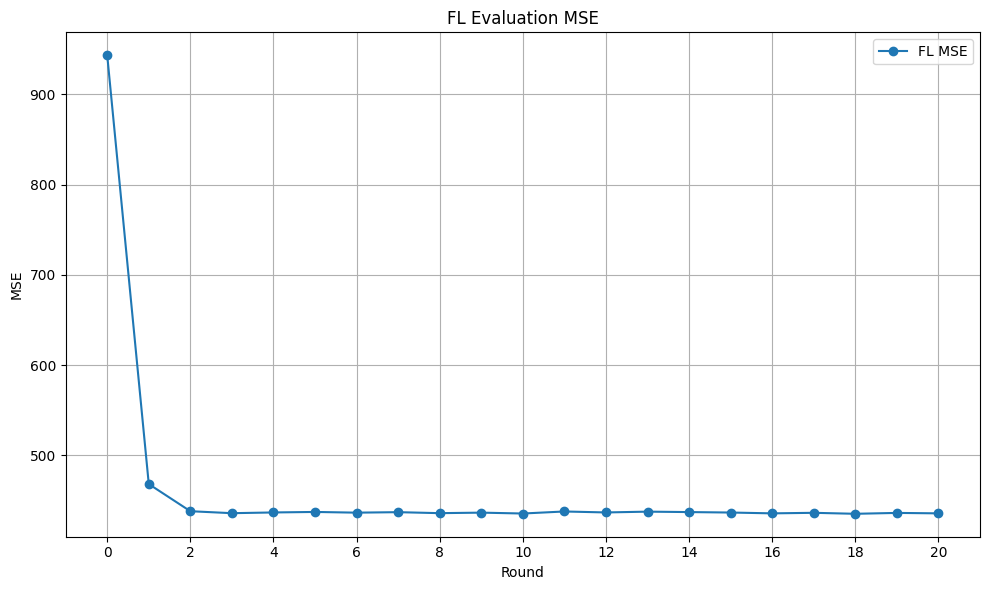

In [ ]:
# FL evaluation results
fl_rounds = list(range(len(eval_fl_mse)))  # Number of rounds for FL evaluation
fl_loss = eval_fl_loss
fl_mse = [mse.item() for mse in eval_fl_mse]

plt.figure(figsize=(10, 6))
plt.plot(fl_rounds, fl_mse, label='FL MSE', marker='o')
plt.title('FL Evaluation MSE')
plt.xlabel('Round')
plt.ylabel('MSE')
plt.xticks(range(0, len(eval_fl_mse), 2))  # Set x-axis ticks at intervals of 2 rounds
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## MSE comparison

### Line graph
> Centralised models and best XGBoost model against FL evaluation metrics of all rounds



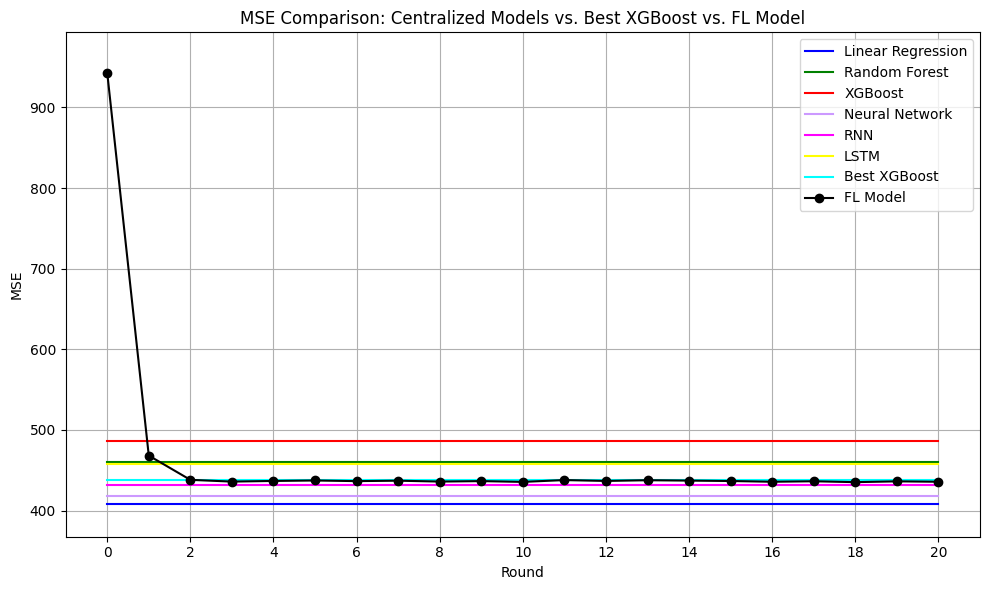

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Centralized model evaluation results
central_eval_results = eval_results[:, 1:].astype(float)  # Exclude model names and convert to float

# Best XGBoost model's MSE
best_xgboost_mse = best_mse

# FL evaluation MSE
fl_mse = [mse.item() for mse in eval_fl_mse]

# Model names
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'RNN', 'LSTM']

# FL rounds
fl_rounds = list(range(len(eval_fl_mse)))

plt.figure(figsize=(10, 6))

# Define colors for each model
light_purple = (0.8, 0.6, 1.0)  # RGB values for light purple
model_colors = ['blue', 'green', 'red',light_purple, 'magenta', 'yellow']

# Define offsets for LSTM and Linear Regression
offsets = [-10, 0, 10, 20, 30, 40]  # Adjust these values as needed

# Plot MSE for each centralized model, best XGBoost model, and FL model
for j, model_name in enumerate(model_names):
    offset = offsets[j] if model_name in ['LSTM', 'Linear Regression'] else 0
    plt.plot(fl_rounds, central_eval_results[j, 0] * np.ones(len(fl_rounds)) + offset, label=f'{model_name}', color=model_colors[j])

# Plot MSE for best XGBoost model
plt.plot(fl_rounds, best_xgboost_mse * np.ones(len(fl_rounds)), label='Best XGBoost', color='cyan')

# Plot MSE for FL model
plt.plot(fl_rounds, fl_mse, label='FL Model', marker='o', color='black')

plt.title('MSE Comparison: Centralized Models vs. Best XGBoost vs. FL Model')
plt.xlabel('Round')
plt.ylabel('MSE')

# Set y-axis limits dynamically based on data range
plt.ylim(min(min(fl_mse), min(central_eval_results[:, 0])) - 50, max(max(fl_mse), max(central_eval_results[:, 0])) + 50)

plt.xticks(range(0, len(eval_fl_mse), 2))  # Set x-axis ticks at intervals of 2 rounds
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## MSE comparison seperately against all models

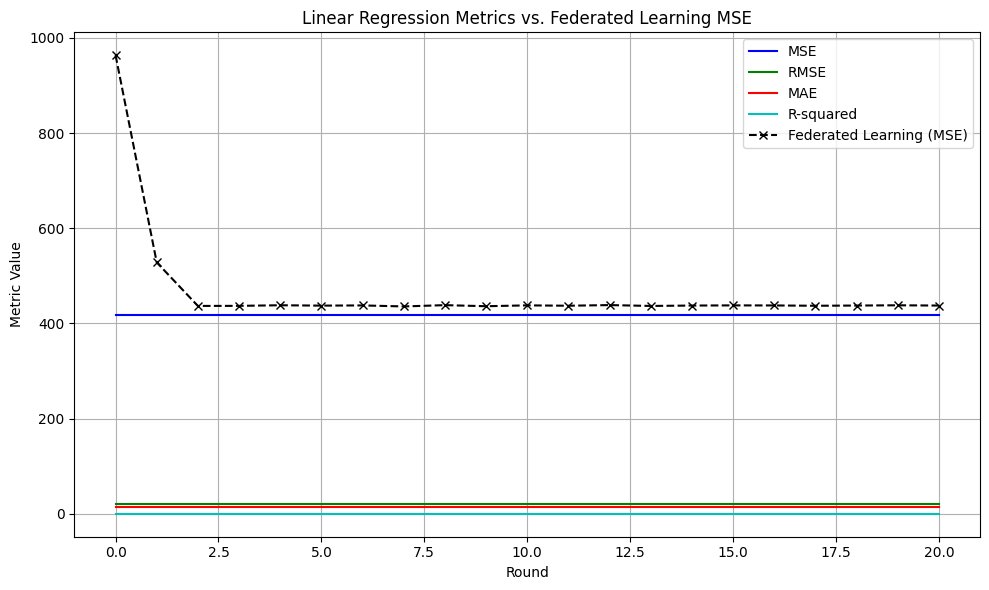

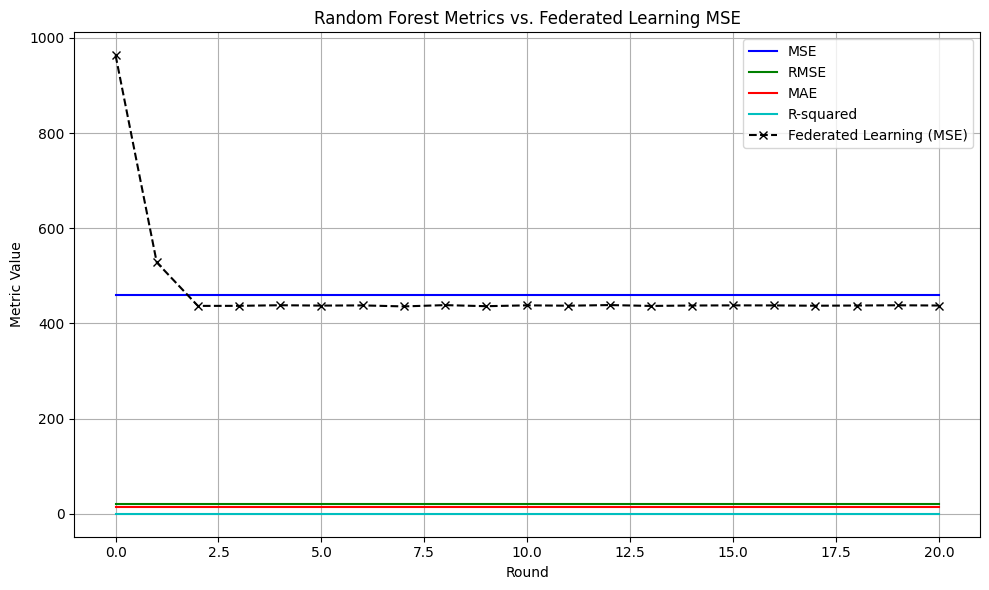

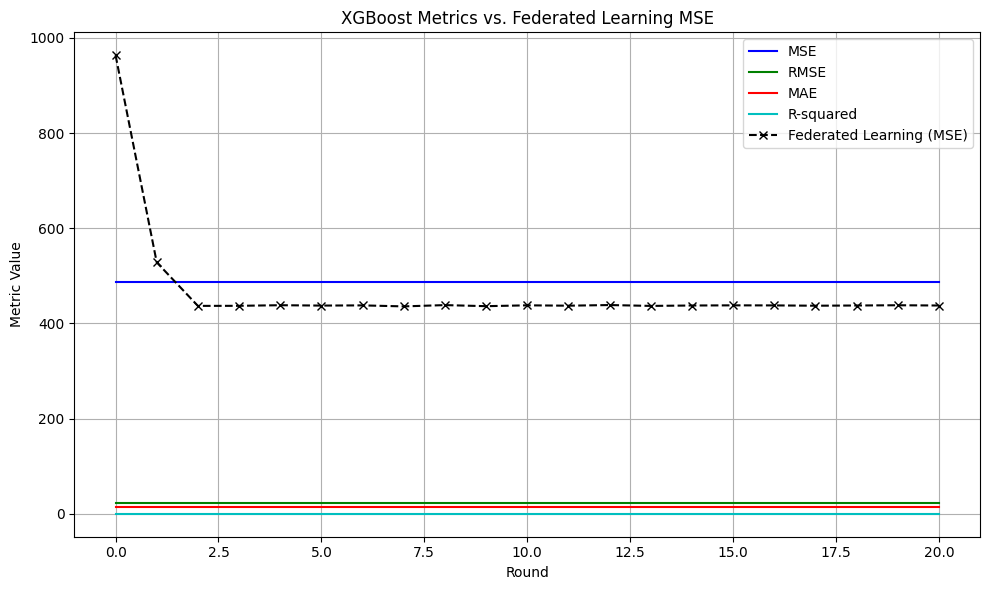

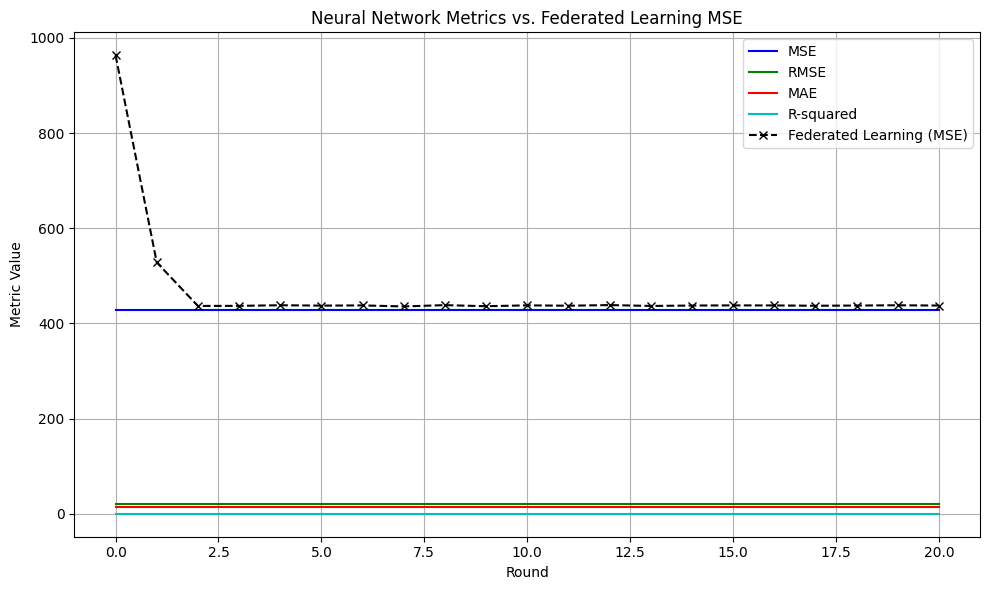

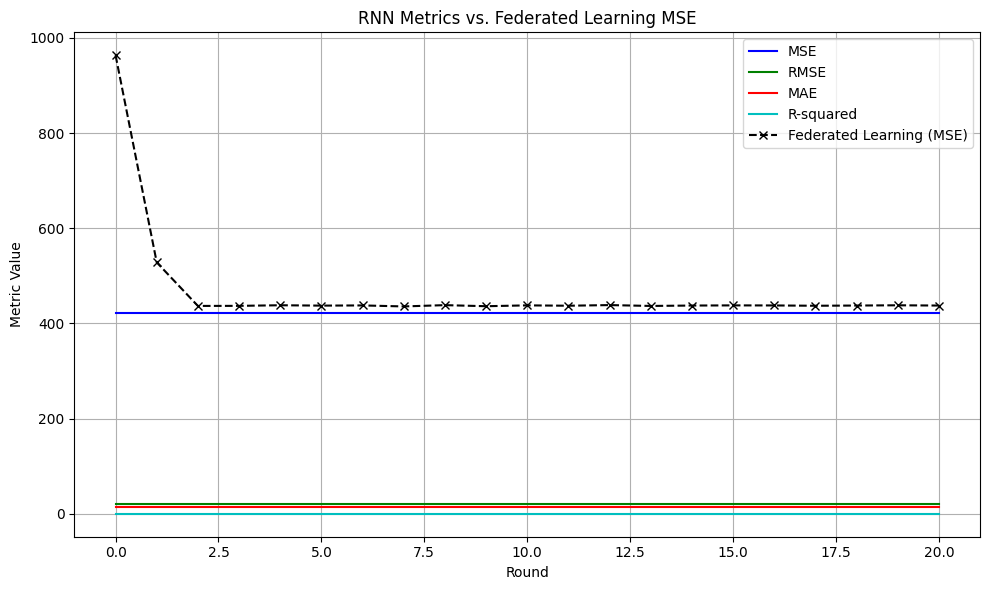

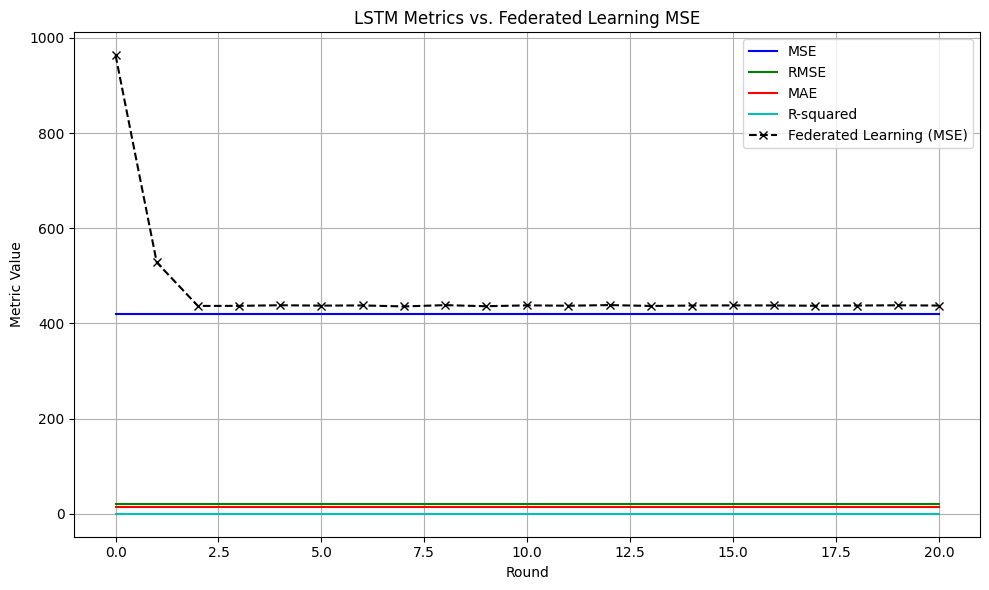

In [ ]:
# Centralized model evaluation results
central_eval_results = eval_results[:, 1:].astype(float)  # Exclude model names and convert to float
central_eval_metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

# Define colors for metrics
metric_colors = ['b', 'g', 'r', 'c']

# Plotting for each centralized model's metrics
for j, model_name in enumerate(model_names):
    plt.figure(figsize=(10, 6))

    # Plot metric values for the current centralized model
    for i, metric in enumerate(central_eval_metrics):
        plt.plot(range(len(fl_loss)), central_eval_results[j, i] * np.ones(len(fl_loss)), color=metric_colors[i], label=f'{metric}')

    # Plot FL evaluation MSE values for all rounds
    plt.plot(range(len(fl_loss)), fl_mse, marker='x', color='k', linestyle='dashed', label='Federated Learning (MSE)')

    plt.title(f'{model_name} Metrics vs. Federated Learning MSE')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Bar graph
> Against the centralised models, best XGBoost, and the Final FL round(round-20) evaluation metrics

need to change to last round(for fl).


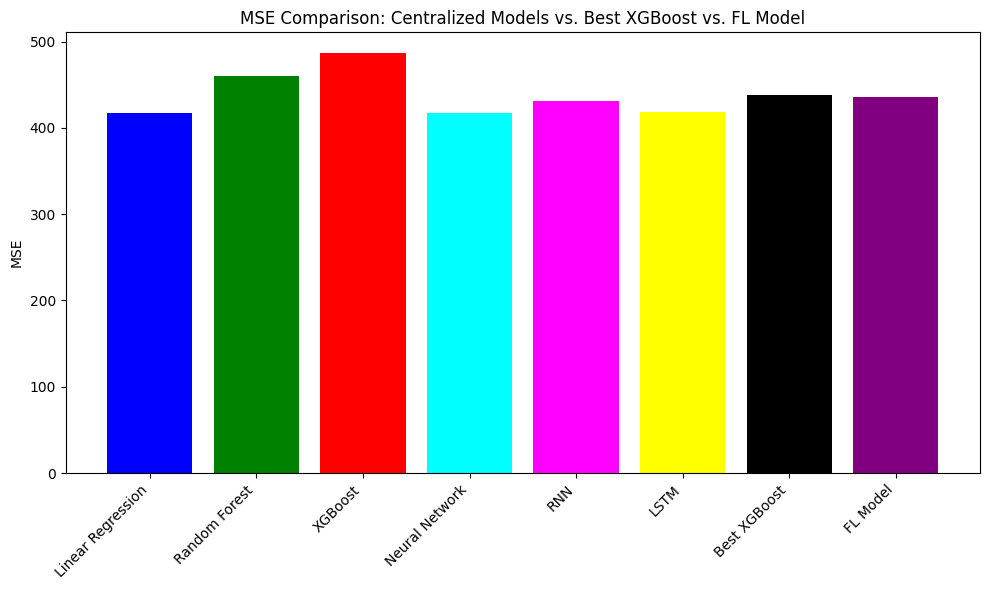

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Centralized model evaluation results
central_eval_results = eval_results[:, 1:].astype(float)  # Exclude model names and convert to float

# Best XGBoost model's MSE
best_xgboost_mse = best_mse

# FL evaluation MSE
fl_mse = [mse.item() for mse in eval_fl_mse]

# Model names
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'RNN', 'LSTM']

# Create a bar plot for MSE comparison
plt.figure(figsize=(10, 6))

# Define colors for each model
model_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# Plot MSE values for each model
for j, model_name in enumerate(model_names):
    plt.bar(model_name, central_eval_results[j, 0], color=model_colors[j])

# Plot MSE value for best XGBoost model
plt.bar('Best XGBoost', best_xgboost_mse, color='black')

# Plot MSE values for FL model
plt.bar('FL Model', fl_mse[-1], color='purple')

plt.title('MSE Comparison: Centralized Models vs. Best XGBoost vs. FL Model')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## XGBoost
Evaluation comparision (Best Centralized vs Federated Approach)

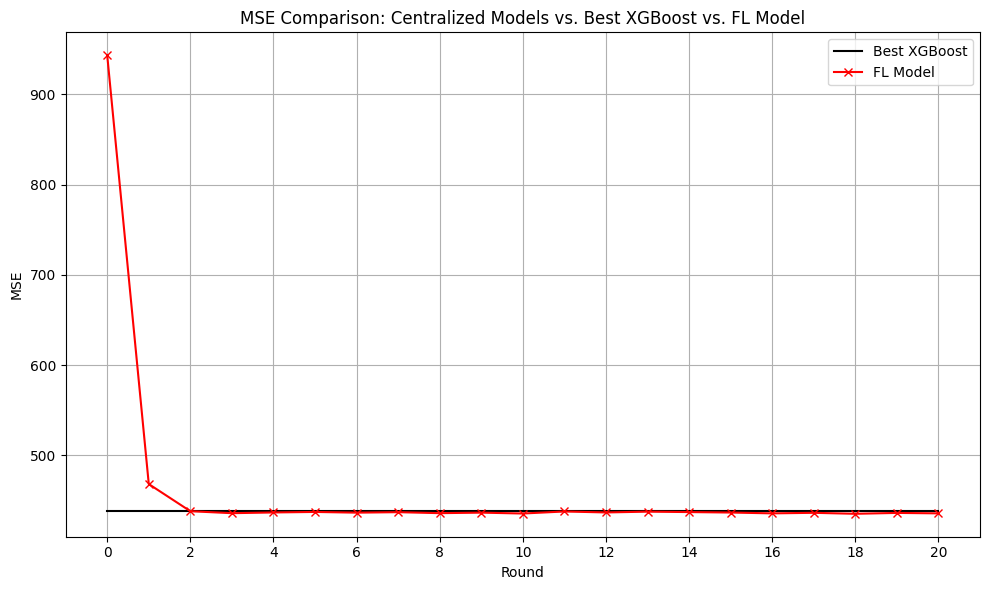

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Best XGBoost model's MSE
best_xgboost_mse = best_mse

# FL evaluation MSE
fl_mse = [mse.item() for mse in eval_fl_mse]

# FL rounds
fl_rounds = list(range(len(eval_fl_mse)))

# Create a line graph comparing MSE between best XGBoost model and FL model
plt.figure(figsize=(10, 6))


# Plot MSE for best XGBoost model
plt.plot(fl_rounds, best_xgboost_mse * np.ones(len(fl_rounds)), label='Best XGBoost', color='black')

# Plot MSE for FL model
plt.plot(fl_rounds, fl_mse, label='FL Model', marker='x', color='red')

plt.title('MSE Comparison: Best XGBoost vs. FL Model')
plt.xlabel('Round')
plt.ylabel('MSE')

plt.xticks(range(0, len(eval_fl_mse), 2))  # Set x-axis ticks at intervals of 2 rounds
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

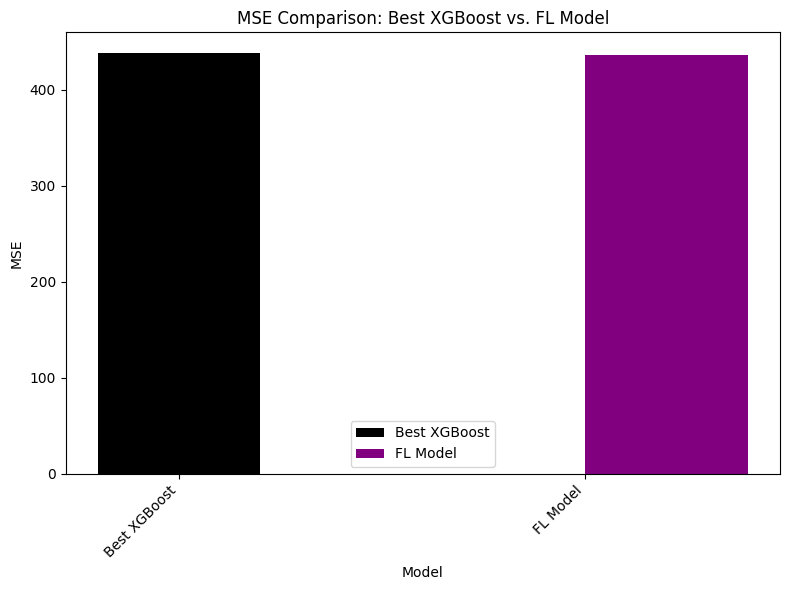

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Best XGBoost model's MSE
best_xgboost_mse = best_mse

# FL evaluation MSE
fl_mse = [mse.item() for mse in eval_fl_mse]

# Create a grouped bar plot comparing MSE between best XGBoost model and FL model
plt.figure(figsize=(8, 6))

# Set the width of the bars
bar_width = 0.4

# Plot MSE value for best XGBoost model
plt.bar('Best XGBoost', best_xgboost_mse, color='black', width=bar_width, label='Best XGBoost')

# Plot MSE values for FL model
plt.bar('FL Model', fl_mse[-1], color='purple', width=bar_width, label='FL Model', align='edge')

plt.title('MSE Comparison: Best XGBoost vs. FL Model')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


# not required

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Centralized model evaluation results
# central_eval_results = eval_results[:, 1:].astype(float)  # Exclude model names and convert to float

# # Best XGBoost model's MSE
# best_xgboost_mse = best_mse

# # FL evaluation MSE
# fl_mse = [mse.item() for mse in eval_fl_mse]

# # Model names
# model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'RNN', 'LSTM']

# # Create a grouped bar chart for MSE comparison
# plt.figure(figsize=(10, 6))

# # Define colors for each model
# model_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# # X-axis positions
# index = np.arange(len(model_names))

# # Bar width
# bar_width = 0.2

# # Plot bars for each model's MSE
# for i, model_name in enumerate(model_names):
#     plt.bar(index + i*bar_width, central_eval_results[:, 0][i], bar_width, color=model_colors[i], label=model_name)

# # Plot bar for best XGBoost model
# plt.bar(index + len(model_names)*bar_width, best_xgboost_mse, bar_width, color='black', label='Best XGBoost', hatch='////')

# # Plot bar for FL model
# plt.bar(index + len(model_names)*bar_width, fl_mse[-1], bar_width, color='purple', label='FL Model', hatch='\\\\\\\\')

# plt.title('MSE Comparison: Centralized Models vs. Best XGBoost vs. FL Model')
# plt.xlabel('Round')
# plt.ylabel('MSE')
# plt.xticks(index + len(model_names)*bar_width/2, model_names)
# plt.legend()

# plt.tight_layout()
# plt.show()


wrong plotting

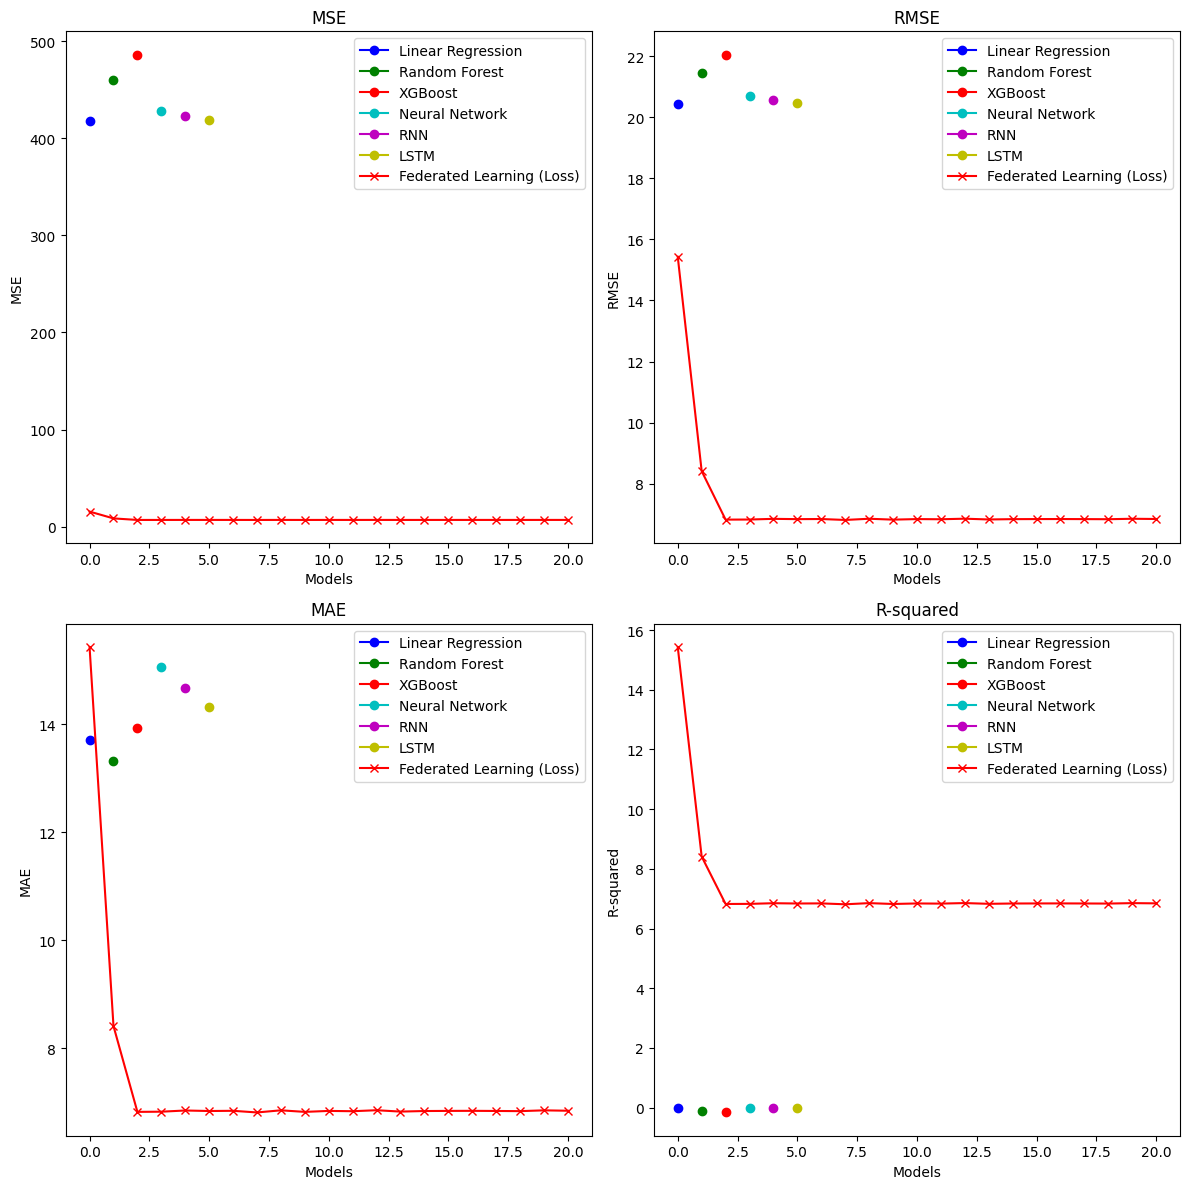

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Centralized model evaluation results
central_eval_results = eval_results[:, 1:].astype(float)  # Exclude model names and convert to float
central_eval_metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

# Select the round for comparison
selected_round = 0  # Change this to the round you want to compare

# Define colors for centralized models
central_model_colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plotting
plt.figure(figsize=(12, 12))

# Compare centralized models' single round value with FL evaluation values for all rounds
for i, metric in enumerate(central_eval_metrics):
    plt.subplot(2, 2, i + 1)

    # Plot single round value for each centralized model
    for j, model_name in enumerate(model_names):
        plt.plot(j, central_eval_results[j, i], marker='o', color=central_model_colors[j], label=model_name)

    # Plot FL evaluation values for all rounds
    plt.plot(range(len(fl_loss)), fl_loss, marker='x', color='r', label='Federated Learning (Loss)')

    plt.title(metric)
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


# Personal Experiments

In [ ]:
# import flwr as fl
# import xgboost as xgb
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from types import SimpleNamespace

# # Define the XGBoost model creation function
# def define_xgboost_model(hyperparameters):
#     return xgb.XGBRegressor(**hyperparameters)


# # Helper function to update the local model parameters
# def set_parameters(model, parameters):
#     model.set_params(**parameters)

# # Helper function to get the local model parameters
# def get_parameters(model):
#     return model.get_xgb_params()

# # Flower Client class
# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, xgb_model, train_data, val_data):
#         self.xgb_model = xgb_model
#         self.train_data = train_data
#         self.val_data = val_data

#     def get_parameters(self, config):
#         return self.xgb_model.get_booster().save_raw()

#     def set_parameters(self, parameters):
#         booster = self.xgb_model.get_booster()
#         booster.load_model(parameters)

#     def fit(self, parameters, config):
#         self.set_parameters(parameters)

#         # Train the XGBoost model on the client's data
#         features = self.train_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
#         target = self.train_data['energy_sum'].values
#         self.xgb_model.fit(features, target)

#         # Return the updated model parameters
#         return self.get_parameters(config)  # Pass config argument here

#     def evaluate(self, parameters, config):
#         self.set_parameters(parameters)

#         # Evaluate the XGBoost model on the client's validation data
#         features = self.val_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
#         target = self.val_data['energy_sum'].values
#         predictions = self.xgb_model.predict(features)
#         loss = mean_squared_error(target, predictions)

#         return loss, len(self.val_data), {}

# # Create an instance of XGBoost model
# hyperparameters = {'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3}
# xgboost_model = define_xgboost_model(hyperparameters)

# # Fit the xgboost_model using training data
# xgboost_model.fit(
#     FL_train_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']],
#     FL_train_set['energy_sum']
# )

# # Create FlowerClient instances
# NUM_CLIENTS = len(FL_train_sets_list)
# clients = [client_fn(cid) for cid in range(NUM_CLIENTS)]

# # Convert XGBoost model parameters to a dictionary
# model_params = xgboost_model.get_xgb_params()

# # Before starting the simulation loop, call fit on each client
# for client in clients:
#     # Fit each client using the XGBoost model parameters
#     client.fit(model_params, config)

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=lambda cid: clients[int(cid)],
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
# )

In [ ]:
# import flwr as fl
# import xgboost as xgb
# import numpy as np
# from sklearn.metrics import mean_squared_error

# # Define the XGBoost model creation function
# def define_xgboost_model(hyperparameters):
#     return xgb.XGBRegressor(**hyperparameters)

# # Helper function to update the local model parameters
# def set_parameters(model, parameters):
#     booster = model.get_booster()
#     booster.load_model(parameters)

# # Helper function to get the local model parameters
# def get_parameters(model):
#     return model.get_booster().save_raw()

# # Flower Client class
# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, xgb_model, train_data, val_data):
#         self.xgb_model = xgb_model
#         self.train_data = train_data
#         self.val_data = val_data

#     def get_parameters(self):
#         return get_parameters(self.xgb_model)

#     def set_parameters(self, parameters):
#         set_parameters(self.xgb_model, parameters)

#     def fit(self, parameters, config):
#         self.set_parameters(parameters)

#         # Train the XGBoost model on the client's data
#         features = self.train_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
#         target = self.train_data['energy_sum'].values
#         self.xgb_model.fit(features, target)

#         # Return the updated model parameters
#         return self.get_parameters()

#     def evaluate(self, parameters, config):
#         self.set_parameters(parameters)

#         # Evaluate the XGBoost model on the client's validation data
#         features = self.val_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']].values
#         target = self.val_data['energy_sum'].values
#         predictions = self.xgb_model.predict(features)
#         loss = mean_squared_error(target, predictions)

#         return loss, len(self.val_data), {}

# # Create an instance of XGBoost model
# hyperparameters = {'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3}
# xgboost_model = define_xgboost_model(hyperparameters)


# # Create FlowerClient instances
# NUM_CLIENTS = 5  # Adjust the number of clients as needed
# clients = [XGBoostClient(xgboost_model, FL_train_set, FL_val_set) for _ in range(NUM_CLIENTS)]

# # Before starting the simulation loop, call fit on each client
# for client in clients:
#     # Fit each client using the XGBoost model parameters
#     client.fit(None, None)  # Initial fit with None parameters

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=lambda cid: clients[cid],
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,  # Define your strategy here
# )


In [ ]:
# def dataloader(data_list, n):
#     for dataset in data_list:
#         lclid = dataset['LCLid'].iloc[0]
#         num_samples = len(dataset)

#         print(f"Loading data for LCLid {lclid}")

#         for i in range(0, num_samples, n):
#             end_idx = min(i + n, num_samples)
#             batch = dataset.iloc[i:end_idx]
#             yield batch

#         print(f"Data loading completed for LCLid {lclid}\n")

# n_samples_per_batch = 5  # Number of samples per batch

# for batch_data in dataloader(FL_train_sets_list, n_samples_per_batch):
#     print(batch_data)


FEDERATED CLIENT

In [ ]:
# import xgboost as xgb

# import flwr as fl
# from flwr.common import Metrics
# # from flwr.common import Weights
# from flwr.common.typing import Parameters
# from collections import OrderedDict
# from typing import Any, Dict, List, Optional, Tuple, Union
# from flwr.common import NDArray, NDArrays


# # # XGBoost model
# # def define_xgboost_model(hyperparameters: dict) -> xgb.XGBModel:
# #     # Hyperparameters for the XGBoost model
# #     model = xgb.XGBModel(**hyperparameters)
# #     return model

# # # Extract hyperparameters from `best_xgb_model` and use it to define the FLOWER client model
# # hyperparameters = best_xgb_model.get_xgb_params()
# # client_xgb_model = define_xgboost_model(hyperparameters)



In [ ]:
# # Define a function to load local training data for each client
# def load_local_data(client_data_list, client_index, batch_size):
#     client_data = client_data_list[client_index]
#     num_samples = len(client_data)

#     # Calculate the starting and ending index for this client's data
#     start_index = 0
#     end_index = start_index + batch_size

#     while start_index < num_samples:
#         # Yield a batch of data
#         yield client_data.iloc[start_index:end_index]

#         # Move to the next batch
#         start_index = end_index
#         end_index = min(start_index + batch_size, num_samples)

# # Example usage
# client_index = 0  # Change this to select a different client
# batch_size = 5   # Number of samples in each batch

# # Load local training data for the selected client
# for batch_data in load_local_data(FL_train_sets_list, client_index, batch_size):
#     print("Loaded batch of data for client", client_index)
#     print(batch_data)


In [ ]:
# import flwr as fl
# import xgboost as xgb
# import numpy as np
# import pandas as pd

# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, client_data, batch_size):
#         self.client_data = client_data
#         self.batch_size = batch_size
#         self.client_xgb_model = None

#     def get_parameters(self):
#         if self.client_xgb_model is None:
#             return np.array([])  # No parameters available initially
#         model_params = self.client_xgb_model.get_booster().save_config()
#         return fl.common.weights_to_parameters(model_params)

#     def fit(self, parameters, config):
#         if self.client_xgb_model is None:
#             hyperparameters = xgb.Booster(model_str=fl.common.parameters_to_weights(parameters))
#             self.client_xgb_model = xgb.XGBModel(**hyperparameters)

#         for batch_data in self.load_local_data(self.client_data, self.batch_size):
#             batch_features = batch_data[["mean_temp", "pressure", "humidity", "windSpeed"]]
#             batch_target = batch_data["energy_sum"]

#             self.client_xgb_model.fit(batch_features, batch_target)

#         updated_model_params = self.client_xgb_model.get_booster().save_config()
#         return fl.common.weights_to_parameters(updated_model_params)

#     def evaluate(self, parameters, config):
#         if self.client_xgb_model is None:
#             return {}  # No evaluation possible without a trained model
#         model_params = self.client_xgb_model.get_booster().save_config()
#         booster = xgb.Booster(model_str=model_params)

#         batch_data = self.load_local_data(self.client_data, len(self.client_data)).next()
#         batch_features = batch_data[["mean_temp", "pressure", "humidity", "windSpeed"]]
#         batch_target = batch_data["energy_sum"]

#         predictions = booster.predict(xgb.DMatrix(batch_features))
#         mse = np.mean((predictions - batch_target)**2)

#         return {"mse": mse}

#     def load_local_data(self, client_data, batch_size):
#         num_samples = len(client_data)
#         start_index = 0
#         end_index = start_index + batch_size

#         while start_index < num_samples:
#             yield client_data.iloc[start_index:end_index]
#             start_index = end_index
#             end_index = min(start_index + batch_size, num_samples)

# # Example usage
# client_index = 0
# batch_size = 5
# client_instance = XGBoostClient(FL_train_sets_list[client_index], batch_size)

# # fl.client.start_numpy_client("[::]:8080", client=client_instance)


Instance class

In [ ]:
# import flwr as fl

# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, model, dataset, targets):
#         self.model = model
#         self.dataset = dataset
#         self.targets = targets

#     def get_parameters(self):
#         # Return the current local model parameters
#         return self.model.get_xgb_params()

#     def fit(self, parameters, config):
#         # Set the model's parameters
#         self.model.set_params(parameters)

#         # Train the model on the local data
#         self.model.fit(self.dataset, self.targets)

#         # Return the updated model parameters
#         return self.model.get_xgb_params()

#     def evaluate(self, parameters, config):
#         # Set the model's parameters
#         self.model.set_params(parameters)

#         # Evaluate the model on the local data
#         evaluation_result = self.model.score(self.dataset, self.targets)

#         # Return the evaluation result
#         return evaluation_result

# # Create an instance of XGBoost model
# xgboost_model = define_xgboost_model(hyperparameters)  # Define this function as mentioned before

# # Create an instance of the XGBoostClient class
# xgboost_client = XGBoostClient(model=xgboost_model, dataset=FL_val_set[["mean_temp", "pressure", "humidity", "windSpeed"]], targets=FL_val_set["energy_sum"])

# # # Start the Flower client
# # fl.client.start_numpy_client(server_address="[SERVER_ADDRESS]", client=xgboost_client)


## Should be doing

### Gated Convolution Neural Network (GCNN)

In [ ]:
# class GatedCNN24(nn.Module):
#     def __init__(self, input_channels, hidden_sizes):
#         super(GatedCNN24, self).__init__()
#         self.input_channels = input_channels
#         self.hidden_sizes = hidden_sizes

#         self.conv1 = nn.Conv2d(self.input_channels, self.hidden_sizes[0], kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(self.hidden_sizes[1], self.hidden_sizes[2], kernel_size=3, padding=1)

#         self.gate_conv1 = nn.Conv2d(self.input_channels, self.hidden_sizes[0], kernel_size=3, padding=1)
#         self.gate_conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
#         self.gate_conv3 = nn.Conv2d(self.hidden_sizes[1], self.hidden_sizes[2], kernel_size=3, padding=1)

#         self.fc1 = nn.Linear(self.hidden_sizes[2], 1)

#     def forward(self, x):
#         # Convolutional layers
#         conv1_out = self.conv1(x)
#         conv2_out = self.conv2(conv1_out)
#         conv3_out = self.conv3(conv2_out)

#         # Gating layers
#         gate_conv1_out = torch.sigmoid(self.gate_conv1(x))
#         gate_conv2_out = torch.sigmoid(self.gate_conv2(conv1_out))
#         gate_conv3_out = torch.sigmoid(self.gate_conv3(conv2_out))

#         # Element-wise multiplication (gating)
#         gated_conv1 = conv1_out * gate_conv1_out
#         gated_conv2 = conv2_out * gate_conv2_out
#         gated_conv3 = conv3_out * gate_conv3_out

#         # Sum along channels
#         gated_sum = gated_conv1 + gated_conv2 + gated_conv3

#         # Global average pooling
#         pooled = torch.mean(gated_sum, dim=[2, 3])

#         # Fully connected layer
#         output = self.fc1(pooled)
#         return output.squeeze()

# class EnergyDataset(Dataset):
#     def __init__(self, features, targets):
#         self.features = features
#         self.targets = targets

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         inputs = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
#         target = torch.tensor(self.targets.iloc[idx], dtype=torch.float32)
#         return inputs, target

# # Define hyperparameters
# input_channels = 4  # Number of features
# hidden_sizes = [10, 8, 1]
# learning_rate = 0.001
# num_epochs = 10
# batch_size = 50

# # Create DataLoader for training
# train_dataset = EnergyDataset(Central_X_train, Central_y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Create the model
# GatedCNN_model = GatedCNN24(input_channels, hidden_sizes)

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(GatedCNN_model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     GatedCNN_model.train()  # Set the model in training mode
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()

#         # Reshape the input tensor to match expected shape [batch_size, channels, height, width]
#         inputs = inputs.view(inputs.size(0), input_channels, 1, 1)

#         outputs = GatedCNN_model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


### Gated Neural Network model

In [ ]:
# # Build the Gated Neural Network model
# inputs = Input(shape=(4,))
# dense_layer = Dense(16, activation='relu')(inputs)

# # Gating mechanism
# dense_gate = Dense(16, activation='sigmoid')(inputs)
# gated_dense = Multiply()([dense_layer, dense_gate])

# output = Dense(1, activation='linear')(gated_dense)

# GNN_model = Model(inputs=inputs, outputs=output)

# # Compile the model
# GNN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# # Train the model
# GNN_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_split=0.2)

Implementing FLower Client

In [ ]:
# import flwr as fl

# from flwr.client import NumPyClient
# import xgboost as xgb
# from sklearn.metrics import accuracy_score
# import io

# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, model, X_train, y_train, X_val, y_val):
#         self.model = model
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_val = X_val
#         self.y_val = y_val

#     def get_parameters(self, config=None):
#         with io.BytesIO() as buffer:
#             self.model.save_model(buffer)
#             return buffer.getvalue()

#     def fit(self, parameters, config):
#         new_model = xgb.XGBRegressor(**config)
#         with io.BytesIO(parameters) as buffer:
#             new_model.load_model(buffer)
#         self.model = new_model

#         self.model.fit(self.X_train, self.y_train)

#         with io.BytesIO() as buffer:
#             self.model.save_model(buffer)
#             return buffer.getvalue()

#     def evaluate(self, parameters, config):
#         new_model = xgb.Booster(params=config, model_str=parameters[0])
#         self.model = new_model

#         y_pred = self.model.predict(self.X_val)
#         accuracy = accuracy_score(self.y_val, y_pred)

#         return accuracy



In [ ]:
# # the best hyperparameters in best_xgb_model
# best_hyperparameters = best_xgb_model.get_xgb_params()

# # Create an instance of your XGBoost model with the best hyperparameters
# best_xgb_model_instance = xgb.XGBRegressor(**best_hyperparameters)


# # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
# client_resources = None
# if DEVICE.type == "cuda":
#     client_resources = {"num_gpus": 1}

# # Define a function to create a virtual client
# def create_virtual_client(lclid):
#     client_data = FL_train_set[FL_train_set['LCLid'] == lclid]
#     X_client = client_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
#     y_client = client_data['energy_sum']
#     return XGBoostClient(best_xgb_model_instance, X_client, y_client,  FL_test_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']], FL_test_set['energy_sum'])

# # Fit the XGBoost model before creating virtual clients
# best_xgb_model_instance.fit(Central_X_train, Central_y_train)

# # Create a list of virtual clients
# virtual_clients = [create_virtual_client(lclid) for lclid in unique_lclids]

# # Define the client function for Flower simulation
# def client_fn(cid: str) -> XGBoostClient:
#     virtual_client = virtual_clients[int(cid)]
#     return virtual_client

# # Define the Flower simulation configuration
# config = fl.server.ServerConfig(num_rounds=5)

# # Start the Flower simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=len(virtual_clients),
#     config=config,
#     strategy=fl.server.strategy.FedAvg(),
#     client_resources=None,  # Adjust client resources as needed
# )
